## 00_7차 파일을 수정한 것으로 논문에 사용된 case1, 2에 대한 소스만 정리함

In [ ]:
# import sys
# print(sys.version)

In [ ]:
# !pip install numpy==1.26.4
# !pip install xgboost==3.0.0
# !pip install scikit-learn==1.5.1
# !pip install shap==0.47.0
# !pip install scipy==1.13.1 
# !pip install matplotlib
# !pip install seaborn 

In [ ]:
# 길이 안자르고 출력하기 
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [12]:
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, classification_report # 분류모델 평가
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score,roc_auc_score # 분류모델 평가
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import shap
import io
from PIL import Image

import pickle
import joblib
from datetime import datetime

## 1. 사전 수행
### 1-1. Confusion Matrix, 모델 평가 함수

In [19]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          filename='confusion_matrix.png'):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    filename:      Filename to save the confusion matrix plot. Default is 'confusion_matrix.png'
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]
    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
        stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)

        #if it is a binary confusion matrix, show some more stats
#         if len(cf)==2:
#             #Metrics for Binary Confusion Matrices
#             precision = cf[1,1] / sum(cf[:,1])
#             recall    = cf[1,1] / sum(cf[1,:])
#             f1_score  = 2*precision*recall / (precision + recall)
#             stats_text = "\n\nAccuracy={:0.4f}\nPrecision={:0.4f}\nRecall={:0.4f}\nF1 Score={:0.4f}".format(
#                 accuracy,precision,recall,f1_score)
#         else:
#             stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)
    plt.savefig(filename, format='png', dpi=300) 
    plt.show()

def calculate_specificity(conf_matrix, positive_class=0):
    tp_tn_sum = conf_matrix.sum() - conf_matrix[positive_class,:].sum() - conf_matrix[:,positive_class].sum() + conf_matrix[positive_class,positive_class]
    fp_fn_sum = conf_matrix[:,positive_class].sum() + conf_matrix[positive_class,:].sum() - 2 * conf_matrix[positive_class,positive_class]
    specificity = tp_tn_sum / (tp_tn_sum + fp_fn_sum)
    return specificity


def evaluate_model_performance(y_true, y_pred, model_name="Model", categories=None, cmap='Blues', figsize=(6,4), positive_class=0, filename='confusion_matrix.png'):
    unique_classes = np.unique(np.concatenate((y_true, y_pred)))
    if categories is None:
        categories = unique_classes
    print("Classes:", unique_classes)

    print(np.unique(y_pred, return_counts=True))
    
    confusion = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix for {model_name}:\n", confusion)
    
    make_confusion_matrix(confusion, 
                          categories=categories,
                          cmap=cmap, 
                          cbar=False, 
                          figsize=figsize,
                          filename=filename)
    
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)
    
    precision = precision_score(y_true, y_pred, pos_label=positive_class, average='binary')
    # print(f"Precision for class {positive_class}:", precision)
    f1 = f1_score(y_true, y_pred, pos_label=positive_class, average='binary')
    print(f"F1 Score for class {positive_class}:", f1)
 

    recall = recall_score(y_true, y_pred, pos_label=positive_class, average='binary')
    print(f"Sensitivity for class {positive_class}:", recall)
    
    
    specificity = None
    if len(unique_classes) == 2:
        specificity = confusion[0,0] / (confusion[0,0] + confusion[0,1])
        print("Specificity:", specificity)
    else:
        specificity = calculate_specificity(confusion, positive_class=positive_class)
        print(f"Specificity for class {positive_class}:", specificity)
        
    



    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "f1": f1
    }


def evaluate_model_performance_weighted(y_true, y_pred, model_name="Model", categories=None, cmap='Blues', figsize=(6,4), positive_class=0, filename='confusion_matrix.png'):
    # unique 클래스 확인 및 출력
    unique_classes = np.unique(np.concatenate((y_true, y_pred)))
    if categories is None:
        categories = unique_classes
    print("Classes:", unique_classes)

    # 각 클래스의 샘플 수를 출력
    print(np.unique(y_pred, return_counts=True))
    
    # 혼동 행렬 계산
    confusion = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix for {model_name}:\n", confusion)
    
    # 혼동 행렬 시각화
    make_confusion_matrix(confusion, 
                          categories=categories,
                          cmap=cmap, 
                          cbar=False, 
                          figsize=figsize,
                          filename=filename)
    
    # 정확도 계산
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)
    
    # F1 점수 계산
    f1 = f1_score(y_true, y_pred, average='weighted',pos_label=positive_class)
    print("F1 Score:", f1)

    # # 정밀도 계산
    precision = precision_score(y_true, y_pred, average='weighted',pos_label=positive_class)
    # print("Precision:", precision)
    
    # 재현율 계산
    recall = recall_score(y_true, y_pred, average='weighted',pos_label=positive_class)
    print("Sensitivity:", recall)
    
    # 특이도 계산
    specificity = None
    if len(unique_classes) == 2:
        specificity = confusion[0,0] / (confusion[0,0] + confusion[0,1])
        print("Specificity:", specificity)
    else:
        tp_tn_sum = confusion.sum() - confusion[positive_class,:].sum() - confusion[:,positive_class].sum() + confusion[positive_class,positive_class]
        fp_fn_sum = confusion[:,positive_class].sum() + confusion[positive_class,:].sum() - 2 * confusion[positive_class,positive_class]
        specificity = tp_tn_sum / (tp_tn_sum + fp_fn_sum)
        print("Specificity for class", positive_class, ":", specificity)


    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,         
        "specificity": specificity,
        "f1": f1
    }    

## 2. 데이터 불러오기 및 전처리

In [9]:
## 변수 type 사전 정의
icu_col_type = {"SubjectNo":str,"SCR01":str,"Dischargewithin6h":str,"lac6h":str,"Age":int,"SEX":str,"Ht":float,"Wt":float,"PBW":float,
                "BMI":float,"INHOS90D":str,"TXANTB30D":str,"TXDIAL30D":str,"DM":str,"Liver_disease":str,"Solid_tumor":str,"AIDS":str,
                "Chronic_kidney_ds":str,"CHF":str,"Myo_infarct":str,"COPD":str,"Peri_vas_ds":str,"Cerebrovasc_ds":str,"Dementia":str,
                "Hemiplegia":str,"Connective_ts_ds":str,"Leukemia":str,"Malig_lymphoma":str,"Peptic_ulcer_ds":str,
                "Charlson_comorbidity_index_total":int,"CFScore":int,"ECOG_Initial":str,"IVS_SBP":float,"IVS_DBP":float,"IVS_MBP":float,
                "IVS_HR":float,"IVS_RR":float,"IVS_BT":float,"SiteInfection_MOSAICS":str,"TypeInfection_MOSAICS":str,"Glucose":float,
                "ArterialPH":float,"PaCO2":float,"PaO2":float,"Bicarbonate":float,"Lactate":float,"WBC":float,"Neutrophil":float,
                "ANC":float,"Hb":float,"Hct":float,"Plt":float,"Na":float,"K":float,"Cl":float,"BUN":float,"Cr":float,"Bilirubin":float,
                "AST":float,"ALT":float,"Albumin":float,"INR":float,"CRP":float,"Procalcitonin":float,"Ddimer":float,"TroponinIT":float,
                "BNP":float,"SOFA_PF":str,"SOFA_PLT":str,"SOFA_BIL":str,"SOFA_Cardio":str,"SOFA_GCS":str,"SOFA_Renal":str,
                "sofa_initial":int,"bundletime_bc":str,"buncletime_abx":str,"bundletime_fluid":str,"buncletime_lac":str,
                "app6h":int,"bundletime_vaso":float,"Lac2":str, "ext":str}

### 파일읽기 icu_raw.SCR01=='1' (응급실 환자)만 읽기, 파일을 따로 만들어 놓음 
# buncletime 관련 변수 수정 완료 연속형 --> 180 이내, 이후로 변경
icu_origin = pd.read_csv('icu_230522_SCR_1_ext_union.csv', dtype = icu_col_type)
print("읽은 파일의 Shape")
print("icu_origin.shape :", icu_origin.shape, ",  Internal 건수 :", icu_origin.ext.value_counts().iloc[0], ",  External 건수 :", icu_origin.ext.value_counts().iloc[1])

### 분석에서 제외 변수
### PBW, SOFA_Cardio > 미팅에서 제외하기로 결정 
### Procalcitonin, Ddimer, BNP (15% 이상 결측) 
### (Case1,2는) sofa_initial 제외
icu_origin = icu_origin.drop(['Procalcitonin','Ddimer', 'BNP', 
                              'SOFA_Cardio', 'PBW'] , axis=1) 
print("불필요 변수 삭제 1차 후 shape,  변수 5개 삭제")
print("icu_origin.shape :", icu_origin.shape)

# Bacteria 확인 관련변수 7개(BacPosSpec, Blood, Urine, Sputum, Bile, Stool, Other) 분석에서 제외하
# 실제 임상에서 예측모델을 적용했을때, 위 변수들은 응급실 내원 당시에는 값을 알 수 없는 변수
print("icu_origin.shape :", icu_origin.shape, ",  Internal 건수 :", icu_origin.ext.value_counts().iloc[0], ",  External 건수 :", icu_origin.ext.value_counts().iloc[1])

#결측치 처리 
# 1)범주형 변수 7종에 대해서 모름 카테고리 추가 icu
print('TXANTB30D 변수 모름 카테고리 2로 추가. null 건수: ', icu_origin.TXANTB30D.isna().sum()) 
icu_origin.TXANTB30D = icu_origin.TXANTB30D.fillna(2)
print('TXANTB30D 변환 후 value counts',icu_origin.TXANTB30D.value_counts() )

print('Liver_disease 변수 모름 카테고리 3으로 추가. null 건수: ', icu_origin.Liver_disease.isna().sum()) 
icu_origin.Liver_disease = icu_origin.Liver_disease.fillna(3)
print('Liver_disease 변환 후 value counts',icu_origin.Liver_disease.value_counts())

print('Leukemia 변수 모름 카테고리 2로 추가. null 건수: ', icu_origin.Leukemia.isna().sum()) 
icu_origin.Leukemia = icu_origin.Leukemia.fillna(2)
print('Leukemia 변환 후 value counts',icu_origin.Leukemia.value_counts())

print('SOFA_PF 변수 모름 카테고리 7로 추가. null 건수: ', icu_origin.SOFA_PF.isna().sum()) 
icu_origin.SOFA_PF = icu_origin.SOFA_PF.fillna(7)
print('SOFA_PF 변환 후 value counts',icu_origin.SOFA_PF.value_counts())

print('SOFA_PLT 변수 모름 카테고리 5로 추가. null 건수: ', icu_origin.SOFA_PLT.isna().sum()) 
icu_origin.SOFA_PLT = icu_origin.SOFA_PLT.fillna(5)
print('SOFA_PLT 변환 후 value counts',icu_origin.SOFA_PLT.value_counts())

print('SOFA_BIL 변수 모름 카테고리 5로 추가. null 건수: ', icu_origin.SOFA_BIL.isna().sum()) 
icu_origin.SOFA_BIL = icu_origin.SOFA_BIL.fillna(5)
print('SOFA_BIL 변환 후 value counts',icu_origin.SOFA_BIL.value_counts())

print('SOFA_Renal 변수 모름 카테고리 5로 추가. null 건수: ', icu_origin.SOFA_Renal.isna().sum()) 
icu_origin.SOFA_Renal = icu_origin.SOFA_Renal.fillna(5)
print('SOFA_Renal 변환 후 value counts',icu_origin.SOFA_Renal.value_counts())


읽은 파일의 Shape
icu_origin.shape : (13570, 82) ,  Internal 건수 : 9808 ,  External 건수 : 3762
불필요 변수 삭제 1차 후 shape,  변수 5개 삭제
icu_origin.shape : (13570, 77)
icu_origin.shape : (13570, 77) ,  Internal 건수 : 9808 ,  External 건수 : 3762
TXANTB30D 변수 모름 카테고리 2로 추가. null 건수:  1
TXANTB30D 변환 후 value counts TXANTB30D
0    9447
1    4122
2       1
Name: count, dtype: int64
Liver_disease 변수 모름 카테고리 3으로 추가. null 건수:  1
Liver_disease 변환 후 value counts Liver_disease
0    12491
1      576
2      502
3        1
Name: count, dtype: int64
Leukemia 변수 모름 카테고리 2로 추가. null 건수:  1
Leukemia 변환 후 value counts Leukemia
0    13432
1      137
2        1
Name: count, dtype: int64
SOFA_PF 변수 모름 카테고리 7로 추가. null 건수:  3
SOFA_PF 변환 후 value counts SOFA_PF
2    5561
1    3660
0    2579
3    1043
4     723
7       3
6       1
Name: count, dtype: int64
SOFA_PLT 변수 모름 카테고리 5로 추가. null 건수:  9
SOFA_PLT 변환 후 value counts SOFA_PLT
0    8019
1    2432
2    1885
3     801
4     424
5       9
Name: count, dtype: int64
SOFA_BIL 변수 모름 카

## 3. 연속형 변수 KNN Imputation

In [10]:
### 분석용 데이터셋과 exteral 구분해서 KNN 돌리기
###KNN Imputation을 하기 위해서 연속형 변수만 추출 (학습용, external 나눠서 수행하기)
icu_knn_df_anal = icu_origin.loc[icu_origin.ext=='0'].select_dtypes(include = ['int32', 'float64']) 
## KNN에 사용하면 안될 변수 삭제 (### 연속형 변수 중 case1,2에서 제외된 sofa_initial과 y값 )
icu_knn_df_anal = icu_knn_df_anal.drop(columns = ['sofa_initial', 'app6h','bundletime_vaso'])  
icu_cols = icu_knn_df_anal.columns
icu_anal_index = icu_knn_df_anal.index
imputer=KNNImputer(n_neighbors=5)
icu_knn_df_anal_filled = imputer.fit_transform(icu_knn_df_anal)
icu_knn_df_anal_filled = pd.DataFrame(icu_knn_df_anal_filled, columns=icu_cols, index = icu_anal_index)

#exteral의 KNN 
icu_knn_df_ext = icu_origin.loc[icu_origin.ext=='1'].select_dtypes(include = ['int32', 'float64']) 
icu_knn_df_ext = icu_knn_df_ext.drop(columns = ['sofa_initial', 'app6h','bundletime_vaso']) 
icu_ext_index = icu_knn_df_ext.index
icu_knn_df_ext_filled = imputer.fit_transform(icu_knn_df_ext)
icu_knn_df_ext_filled = pd.DataFrame(icu_knn_df_ext_filled, columns=icu_cols,  index = icu_ext_index)

# 원본 복사해 놓기
icu = icu_origin.copy()

# KNN 결과 반영하기 (external도 반영함 ) 
icu_origin.loc[icu_origin.ext=='0', icu_cols]=icu_knn_df_anal_filled[icu_cols]
icu_origin.loc[icu_origin.ext=='1', icu_cols]=icu_knn_df_ext_filled[icu_cols]

## 4.데이터셋 만들기

##### lactate 결측치는 Knn imputation을 수행 해서 없음 (최종 제외대상 아님)
##### Dischargewithin6h: 6-hour 내 퇴실 여부 (제외대상자)
##### lac6h: 6-hour 내 lactate 검사 여부 (제외 대상자) 
##### app6h: 6-hour bundle 성공 여부 - 승압제 사용 (case1의 종속변수)
##### Lac2: 6-hour 측정한 lactate 값 2 이상 유무

In [11]:
# icu_origin.columns
# print(icu_origin.SCR01.value_counts())
# print(icu_origin['Dischargewithin6h'].value_counts())
# print(icu_origin['lac6h'].value_counts())
# pd.crosstab(index=icu_origin['Dischargewithin6h'], columns=icu_origin['lac6h'], margins=True)

##[[Case1]]
## case 01: 6시간내 퇴원 환자 제외
icu_data_01 = icu_origin.loc[icu_origin.Dischargewithin6h =='0'].copy()
## case 02 : 6시간내 퇴원환자와 6시간 이내  lactate 검사자 제외
icu_data_02 =icu_data_01.loc[icu_data_01.lac6h=='1'].copy()
## case2의 y값 신규 생성 target, 승압제 사용하고, Lactate 2이상
icu_data_02['target']=0
icu_data_02.loc[(icu_data_02.app6h==1) & (icu_data_02.Lac2=='1'),'target']=1  # case 2번 분석의 y value

# dummy화 처리 전에 ext 변수 int로 변경하기
icu_data_01['ext'] = icu_data_01['ext'].astype(int) 
# y를 학습용 ext 구분,  case 1의 종속 변수 : app6h
y_01 = icu_data_01.loc[icu_data_01.ext ==0]['app6h']  
y_01_ext = icu_data_01.loc[icu_data_01.ext ==1]['app6h'] 
#x에서 불필요 변수 제거
x_01 = icu_data_01.drop(['SubjectNo','SCR01','Dischargewithin6h','lac6h',
                         'app6h', 'bundletime_vaso','Lac2', 'sofa_initial'], axis=1) 
x_col_01 = x_01.columns
# dummy화 처리
xd_01 = pd.get_dummies(x_01[x_col_01], drop_first=True)
# 학습용, ext 구분하기 
xd_01_ext = xd_01.loc[xd_01.ext ==1]
xd_01_ext = xd_01_ext.drop(['ext'], axis=1) 
xd_01 = xd_01.loc[xd_01.ext ==0]
xd_01 = xd_01.drop(['ext'], axis=1) 
xd_col_01 = xd_01.columns

xd_train_01, xd_test_01, yd_train_01, yd_test_01 = train_test_split(xd_01, y_01, random_state=10, test_size = 0.1)
xd_train_01, xd_valid_01, yd_train_01, yd_valid_01 = train_test_split(xd_train_01, yd_train_01, random_state=10, test_size = 0.11)
xd_train_01 = pd.DataFrame(xd_train_01 , columns= xd_col_01)
xd_valid_01 = pd.DataFrame(xd_valid_01, columns= xd_col_01)
xd_test_01 = pd.DataFrame(xd_test_01, columns= xd_col_01)
print(xd_train_01.shape, xd_valid_01.shape, xd_test_01.shape, len(yd_train_01), len(yd_valid_01), len(yd_test_01))

##[[case 2]
icu_data_02['ext'] = icu_data_02['ext'].astype(int) 

# y를 학습용 ext 구분
y_02 = icu_data_02.loc[icu_data_02.ext ==0]['target'].astype('int32') 
y_02_ext = icu_data_02.loc[icu_data_02.ext ==1]['target'].astype('int32') 

#x에서 불필요 변수 제거
x_02 = icu_data_02.drop(['SubjectNo','SCR01','Dischargewithin6h','lac6h',
                         'app6h', 'bundletime_vaso','Lac2', 'Lactate', 'target','sofa_initial'], axis=1) 
x_col_02 = x_02.columns
# dummy화 처리
xd_02 = pd.get_dummies(x_02[x_col_02], drop_first=True)

# 학습용, ext 구분하기 
xd_02_ext = xd_02.loc[xd_02.ext ==1]
xd_02_ext = xd_02_ext.drop(['ext'], axis=1) 
xd_02 = xd_02.loc[xd_02.ext ==0]
xd_02 = xd_02.drop(['ext'], axis=1) 
xd_col_02= xd_02.columns

xd_train_02, xd_test_02, yd_train_02, yd_test_02 = train_test_split(xd_02, y_02, random_state=10, test_size = 0.1)
xd_train_02, xd_valid_02, yd_train_02, yd_valid_02 = train_test_split(xd_train_02, yd_train_02, random_state=10, test_size = 0.11)
xd_train_02 = pd.DataFrame(xd_train_02, columns =xd_col_02)
xd_valid_02 = pd.DataFrame(xd_valid_02, columns =xd_col_02)
xd_test_02 = pd.DataFrame(xd_test_02, columns =xd_col_02)
print(xd_train_02.shape, xd_valid_02.shape, xd_test_02.shape, len(yd_train_02), len(yd_valid_02), len(yd_test_02))

(7648, 124) (946, 124) (955, 124) 7648 946 955
(7333, 121) (907, 121) (916, 121) 7333 907 916


## 5. 모델링

### 5-1. Logistic Regression

#### Logistic Case 1

모델이 저장되었습니다: LRM_01_package.joblib
0.8370875479285098


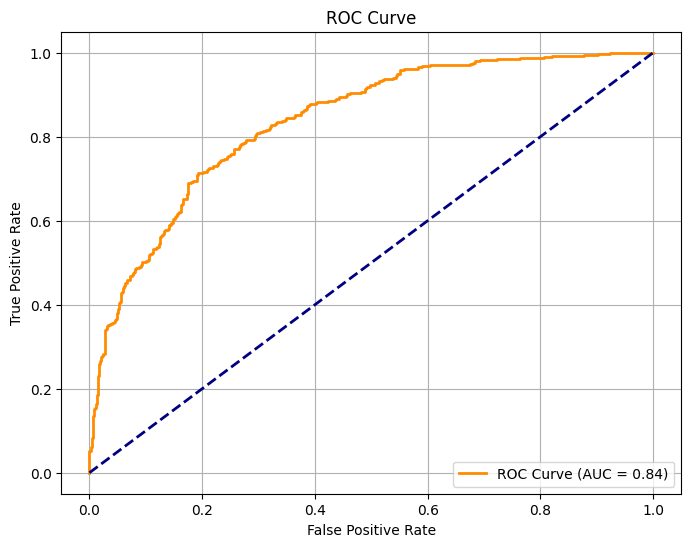

Classes: [0 1]
(array([0, 1]), array([527, 428], dtype=int64))
Confusion Matrix for LRM_01:
 [[413 121]
 [114 307]]


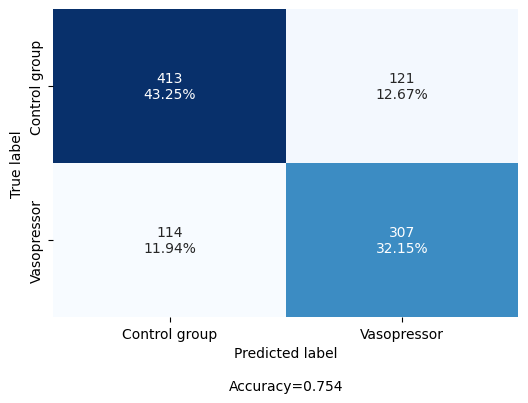

Accuracy: 0.7539267015706806
F1 Score for class 1: 0.7232037691401649
Sensitivity for class 1: 0.7292161520190024
Specificity: 0.7734082397003745


In [34]:
## 로지스틱 회귀 분석 전 정규화
 
scaler = StandardScaler()    
xd_train_tf_01 = scaler.fit_transform(xd_train_01)
xd_valid_tf_01 = scaler.transform(xd_valid_01)
xd_test_tf_01 = scaler.transform(xd_test_01)
xd_ext_tf_01 = scaler.transform(xd_01_ext)

# 변수명 원본 이름 사용 (이 경우 원본 변수명을 DataFrame 컬럼 이름으로 설정)
xd_train_tf_01 = pd.DataFrame(xd_train_tf_01, columns=xd_train_01.columns)
xd_valid_tf_01 = pd.DataFrame(xd_valid_tf_01, columns=xd_valid_01.columns)
xd_test_tf_01 = pd.DataFrame(xd_test_tf_01, columns=xd_test_01.columns)
xd_ext_tf_01 = pd.DataFrame(xd_ext_tf_01, columns=xd_01_ext.columns)

LRM_01 = LogisticRegression(max_iter=500)
LRM_01_result = LRM_01.fit(xd_train_tf_01, yd_train_01)
LRM_01_pred = LRM_01.predict(xd_test_tf_01) 

## 모델 저장
model_package = {
    'model': LRM_01,
    'scaler': scaler,
    'predictions': LRM_01_pred,
    'feature_names': xd_train_01.columns.tolist(),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

joblib.dump(model_package, 'LRM_01_package.joblib')
print("모델이 저장되었습니다: LRM_01_package.joblib")

LRM_01_pred_proba = LRM_01.predict_proba(xd_test_tf_01)[:, 1]  # 양성 클래스 확률 추출

# ROC Curve 계산
LRM_01_fpr, LRM_01_tpr, LRM_01_thresholds = roc_curve(yd_test_01, LRM_01_pred_proba)
LRM_01_roc_auc = auc(LRM_01_fpr, LRM_01_tpr)
print(LRM_01_roc_auc)

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(LRM_01_fpr, LRM_01_tpr, label=f'ROC Curve (AUC = {LRM_01_roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

target_names =  ["Control group", "Vasopressor"]
rlt_LRM_01 = evaluate_model_performance(yd_test_01, LRM_01_pred, model_name="LRM_01", categories=target_names, positive_class=1, filename = "01_confusion_matrix_Logistic_case1_internal.png")

In [15]:
# 모델 불러오기
# ============================================
# loaded_package = joblib.load('LRM_01_package.joblib')

# loaded_model = loaded_package['model']
# loaded_scaler = loaded_package['scaler']
# loaded_predictions = loaded_package['predictions']

# print(f"모델 저장 시간: {loaded_package['timestamp']}")

# # 불러온 모델로 새로운 예측
# new_data_scaled = loaded_scaler.transform(new_data)
# new_predictions = loaded_model.predict(new_data_scaled)

In [ ]:
# # 변수 Coef.
# lrm_coef_01= pd.DataFrame(LRM_01.coef_,columns=xd_train_01.columns)
# lrm_coef_01.T.sort_values(by=0, ascending=False).head(20)

In [ ]:
# explainer = shap.Explainer(LRM_01, xd_train_tf_01)
# shap_values = explainer(xd_test_tf_01)

# top_n = 20

In [ ]:
# plt.figure(figsize=(10, 6))
# shap.summary_plot(shap_values, xd_test_tf_01, plot_type="bar", show=False, max_display=top_n)
# plt.show()

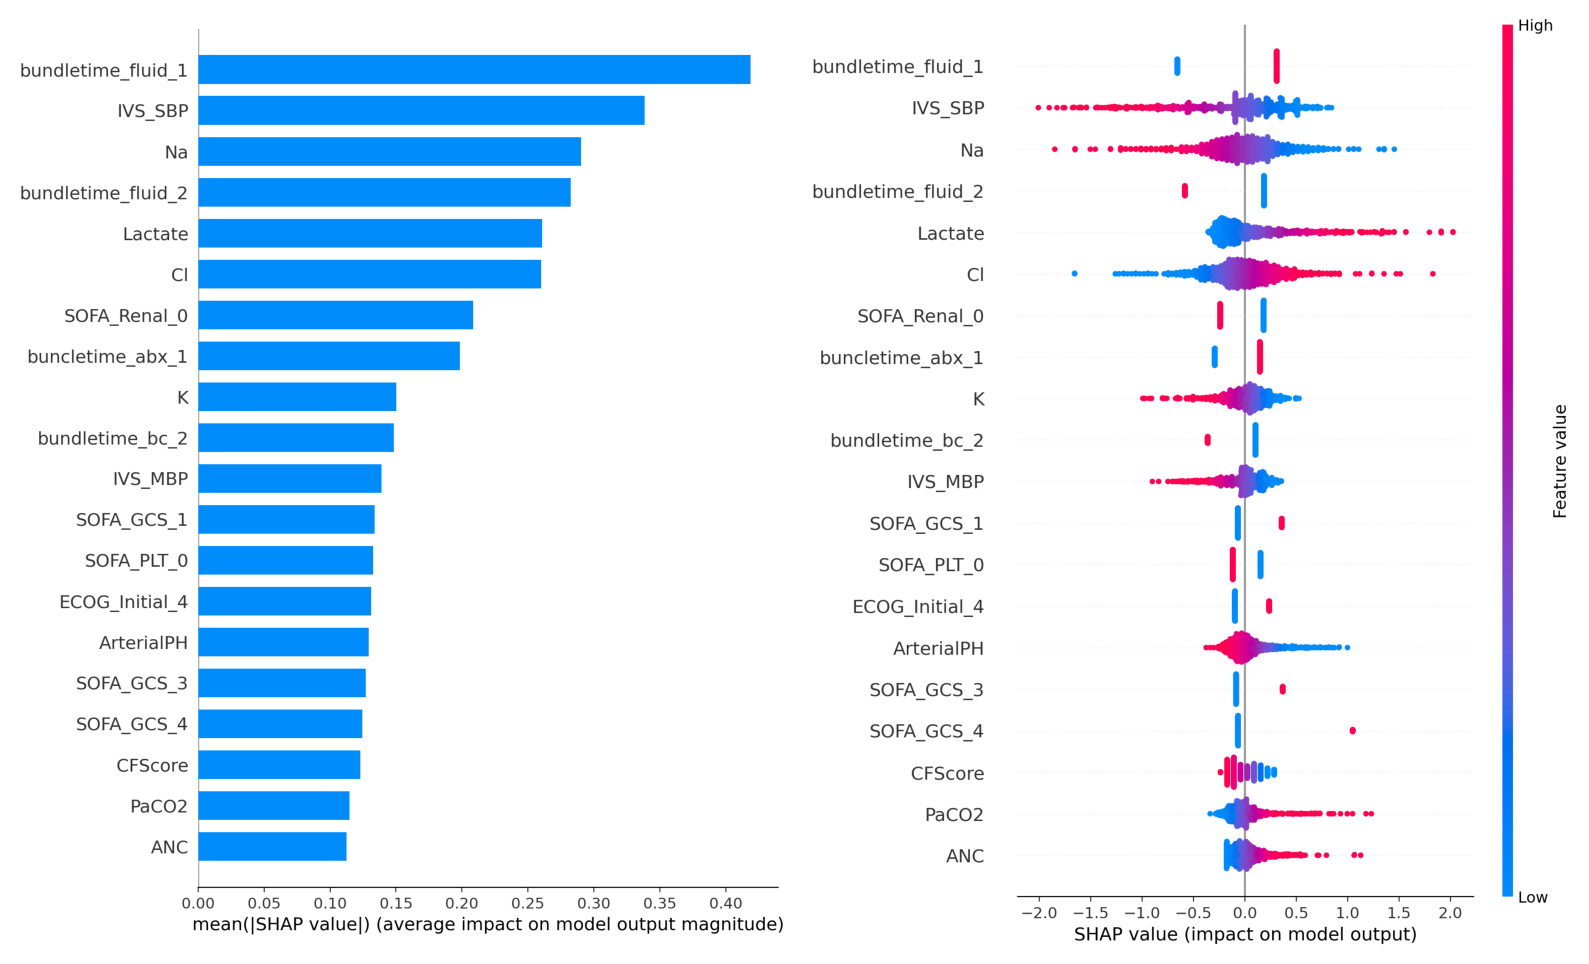

In [21]:
explainer = shap.Explainer(LRM_01, xd_train_tf_01)
shap_values = explainer(xd_test_tf_01)

top_n = 20

#===== summary plot 이미지를 임시 버퍼에 저장 =====
plt.figure(figsize=(6, 6))
shap.summary_plot(shap_values, xd_test_tf_01, plot_type="bar", show=False, max_display=top_n)
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', dpi=200)
plt.close()
buf.seek(0)
img0 = Image.open(buf)

plt.figure(figsize=(6, 6))
shap.summary_plot(shap_values, xd_test_tf_01, show=False, max_display=top_n)
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', dpi=200)
plt.close()
buf.seek(0)
img1 = Image.open(buf)


fig, ax = plt.subplots(1, 2, figsize=(16, 12),
                       gridspec_kw={'width_ratios': [1,1 ]})

# ===== 왼쪽 Bar Plot =====
ax[0].imshow(img0)
ax[0].axis('off')

# ===== 오른쪽 summary plot =====
ax[1].imshow(img1)
ax[1].axis('off')
# ax[1].set_title('Local Explanation Summary', fontsize=13, pad=15)
plt.savefig(fname = '101_feaure_importance_logistic_case1.png',format='png', bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()


In [ ]:
# # ===== summary plot 이미지를 임시 버퍼에 저장 =====
# plt.figure(figsize=(6, 6))
# shap.summary_plot(shap_values, xd_test_tf_01, show=False, max_display=top_n)
# # plt.savefig(buf, format='png', bbox_inches='tight', dpi=200)
# plt.show()

0.8033780217263022


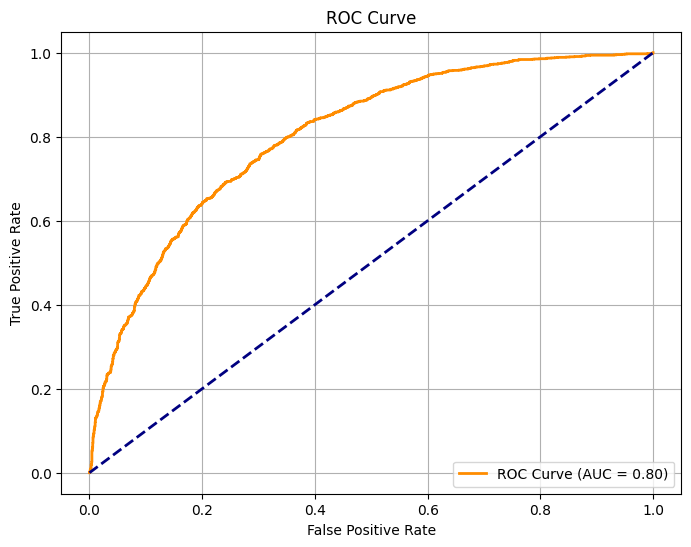

Classes: [0 1]
(array([0, 1]), array([1938, 1687], dtype=int64))
Confusion Matrix for LRM_01:
 [[1503  578]
 [ 435 1109]]


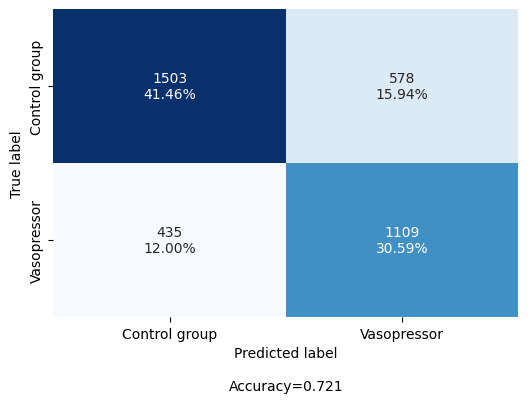

Accuracy: 0.720551724137931
F1 Score for class 1: 0.6864747756112659
Sensitivity for class 1: 0.7182642487046632
Specificity: 0.7222489187890437


In [35]:
LRM_01_pred_ext_proba = LRM_01.predict_proba(xd_ext_tf_01)[:, 1]  # 양성 클래스 확률 추출

# ROC Curve 계산
LRM_01_ext_fpr, LRM_01_ext_tpr, LRM_01_ext_thresholds = roc_curve(y_01_ext, LRM_01_pred_ext_proba)
LRM_01_ext_roc_auc = auc(LRM_01_ext_fpr, LRM_01_ext_tpr)
print(LRM_01_ext_roc_auc)

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(LRM_01_ext_fpr, LRM_01_ext_tpr, label=f'ROC Curve (AUC = {LRM_01_ext_roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

LRM_01_pred_ext = LRM_01.predict(xd_ext_tf_01)
target_names =  ["Control group", "Vasopressor"]
rlt_LRM_01_ext = evaluate_model_performance(y_01_ext, LRM_01_pred_ext, model_name="LRM_01", categories=target_names, positive_class=1, filename = "02_confusion_matrix_Logistic_case1_external.png")

#### Logistic Case2

모델이 저장되었습니다: LRM_02_package.joblib
0.8100172429736242


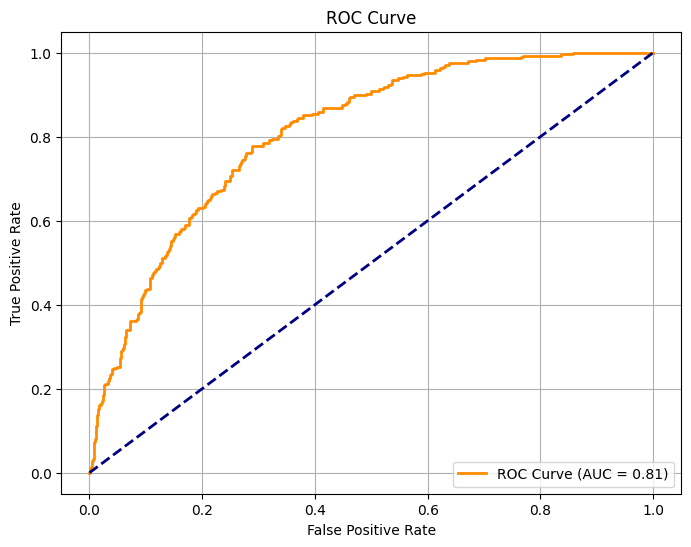

Classes: [0 1]
(array([0, 1]), array([492, 424], dtype=int64))
Confusion Matrix for LRM_02:
 [[428 191]
 [ 64 233]]


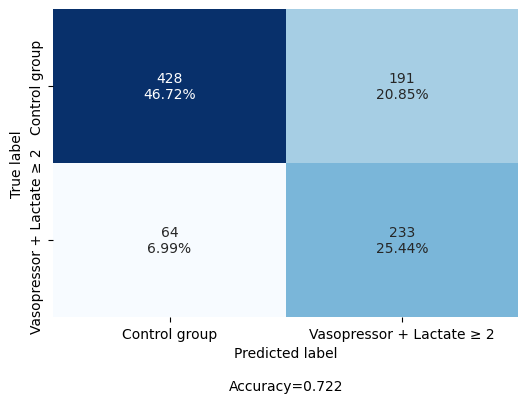

Accuracy: 0.7216157205240175
F1 Score for class 1: 0.6463245492371706
Sensitivity for class 1: 0.7845117845117845
Specificity: 0.691437802907916


In [36]:
## case 2 로지스틱 회귀 분석 
scaler = StandardScaler()  
  
xd_train_tf_02 = scaler.fit_transform(xd_train_02)
xd_valid_tf_02 = scaler.transform(xd_valid_02)
xd_test_tf_02 = scaler.transform(xd_test_02)
xd_ext_tf_02 = scaler.transform(xd_02_ext)

# 변수명 원본 이름 사용 (이 경우 원본 변수명을 DataFrame 컬럼 이름으로 설정)
xd_train_tf_02 = pd.DataFrame(xd_train_tf_02, columns=xd_train_02.columns)
xd_valid_tf_02 = pd.DataFrame(xd_valid_tf_02, columns=xd_valid_02.columns)
xd_test_tf_02 = pd.DataFrame(xd_test_tf_02, columns=xd_test_02.columns)
xd_ext_tf_02 = pd.DataFrame(xd_ext_tf_02, columns=xd_02_ext.columns)

# LRM = LogisticRegression(max_iter=500)
LRM_02 = LogisticRegression( class_weight='balanced', 
#                         random_state = 1,
#                         multi_class= 'auto',
                        max_iter=1000)
LRM_02_result = LRM_02.fit(xd_train_tf_02, yd_train_02)
LRM_02_pred = LRM_02.predict(xd_test_tf_02) 

## 모델 저장
model_package = {
    'model': LRM_02,
    'scaler': scaler,
    'predictions': LRM_02_pred,
    'feature_names': xd_train_02.columns.tolist(),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

joblib.dump(model_package, 'LRM_02_package.joblib')
print("모델이 저장되었습니다: LRM_02_package.joblib")

LRM_02_pred_proba = LRM_02.predict_proba(xd_test_tf_02)[:, 1]  # 양성 클래스 확률 추출

# ROC Curve 계산
LRM_02_fpr, LRM_02_tpr, LRM_02_thresholds = roc_curve(yd_test_02, LRM_02_pred_proba)
LRM_02_roc_auc = auc(LRM_02_fpr, LRM_02_tpr)
print(LRM_02_roc_auc)

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(LRM_02_fpr, LRM_02_tpr, label=f'ROC Curve (AUC = {LRM_02_roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

LRM_02_pred = LRM_02.predict(xd_test_tf_02)
target_names = ["Control group","Vasopressor + Lactate ≥ 2"]
rlt_LRM_02 = evaluate_model_performance(yd_test_02, LRM_02_pred, model_name="LRM_02", categories=target_names, positive_class=1, filename = "03_confusion_matrix_Logistic_case2_internal.png")

In [ ]:
# # 변수 Coef.
# lrm_coef_02= pd.DataFrame(LRM_02.coef_,columns=xd_train_02.columns)
# lrm_coef_02.T.sort_values(by=0, ascending=False).head(20)

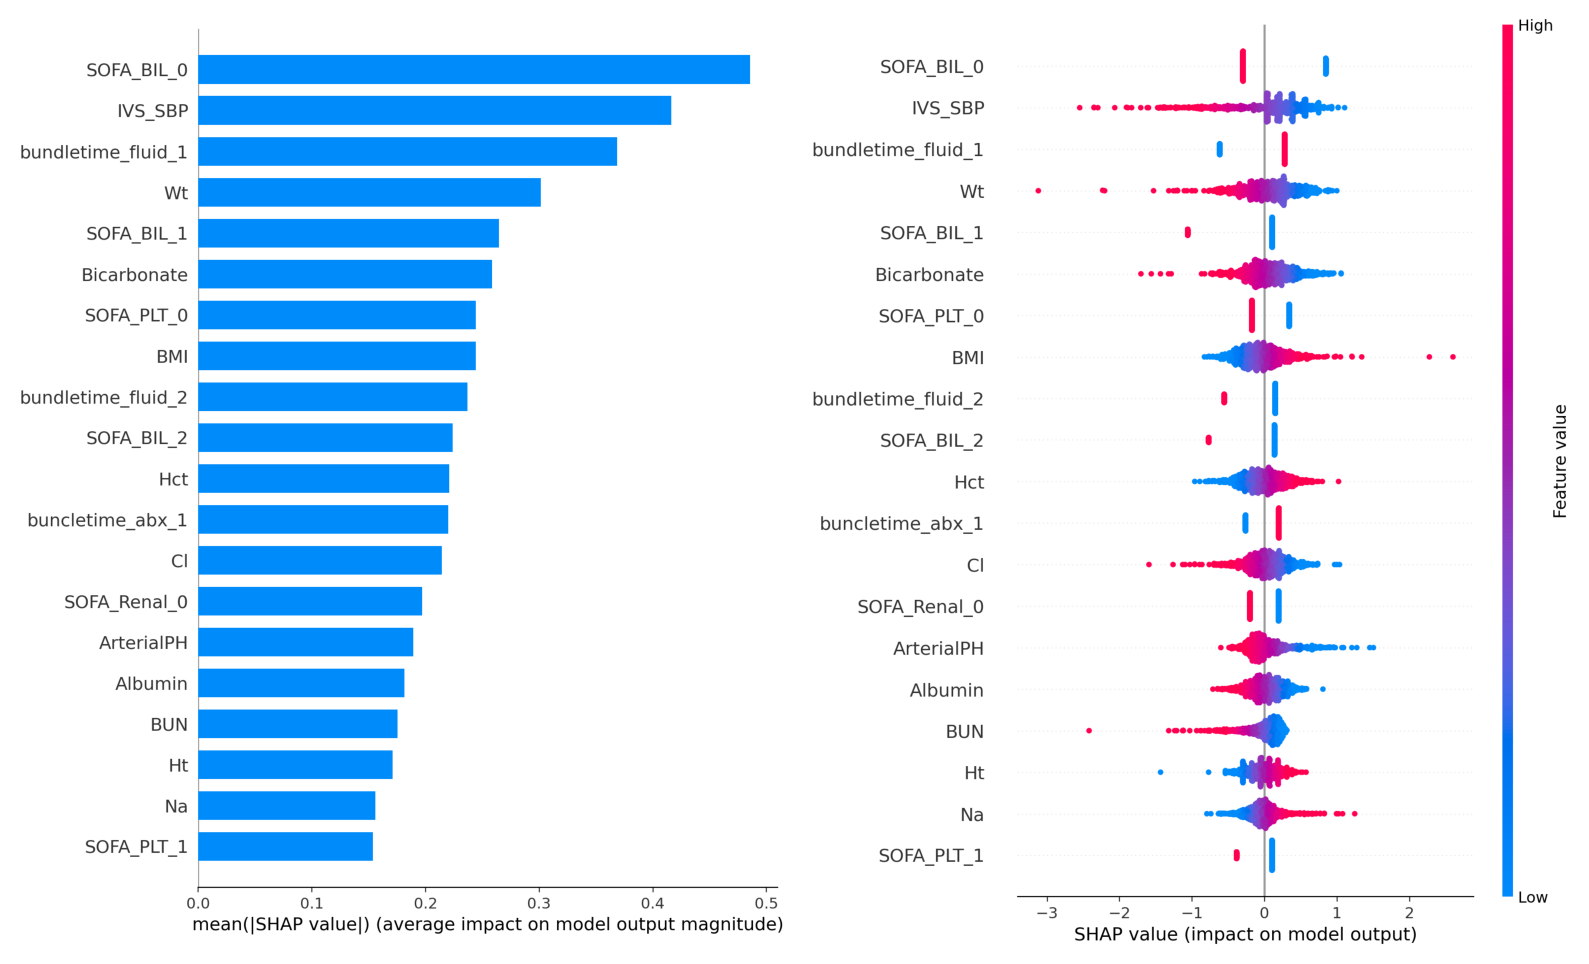

In [29]:
explainer = shap.Explainer(LRM_02, xd_train_tf_02)
shap_values = explainer(xd_test_tf_02)

top_n = 20
#===== summary plot 이미지를 임시 버퍼에 저장 =====
plt.figure(figsize=(6, 6))
shap.summary_plot(shap_values, xd_test_tf_02, plot_type="bar", show=False, max_display=top_n)
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', dpi=200)
plt.close()
buf.seek(0)
img0 = Image.open(buf)

plt.figure(figsize=(6, 6))
shap.summary_plot(shap_values, xd_test_tf_02, show=False, max_display=top_n)
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', dpi=200)
plt.close()
buf.seek(0)
img1 = Image.open(buf)


fig, ax = plt.subplots(1, 2, figsize=(16, 12),
                       gridspec_kw={'width_ratios': [1,1 ]})

# ===== 왼쪽 Bar Plot =====
ax[0].imshow(img0)
ax[0].axis('off')

# ===== 오른쪽 summary plot =====
ax[1].imshow(img1)
ax[1].axis('off')
# ax[1].set_title('Local Explanation Summary', fontsize=13, pad=15)
plt.savefig(fname = '102_feaure_importance_logistic_case2.png',format='png', bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

0.8103552432154193


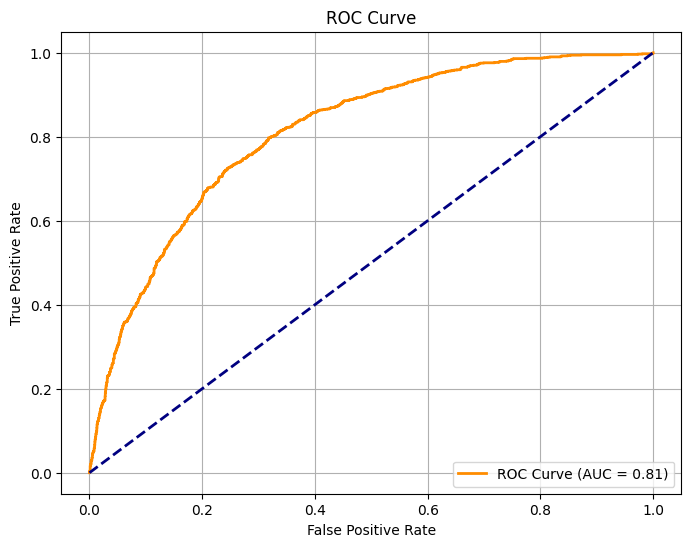

Classes: [0 1]
(array([0, 1]), array([1765, 1757], dtype=int64))
Confusion Matrix for LRM_02:
 [[1536  776]
 [ 229  981]]


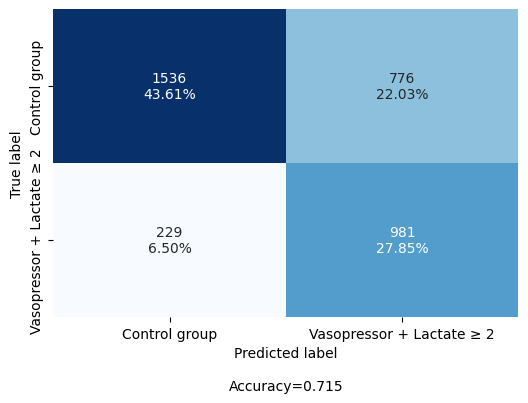

Accuracy: 0.7146507666098807
F1 Score for class 1: 0.6612740141557129
Sensitivity for class 1: 0.8107438016528926
Specificity: 0.6643598615916955


In [37]:
LRM_02_pred_ext_proba = LRM_02.predict_proba(xd_ext_tf_02)[:, 1]  # 양성 클래스 확률 추출

# ROC Curve 계산
LRM_02_ext_fpr, LRM_02_ext_tpr, LRM_02_ext_thresholds = roc_curve(y_02_ext, LRM_02_pred_ext_proba)
LRM_02_ext_roc_auc = auc(LRM_02_ext_fpr, LRM_02_ext_tpr)
print(LRM_02_ext_roc_auc)

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(LRM_02_ext_fpr, LRM_02_ext_tpr, label=f'ROC Curve (AUC = {LRM_02_ext_roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

LRM_02_pred_ext = LRM_02.predict(xd_ext_tf_02)
target_names = ["Control group","Vasopressor + Lactate ≥ 2"]
rlt_LRM_02_ext = evaluate_model_performance(y_02_ext, LRM_02_pred_ext , model_name="LRM_02", categories=target_names, positive_class=1, filename ="04_confusion_matrix_Logistic_case2_external.png")

### Tree 모델

In [31]:
### tree 모델 그리드 써치 


hyper_parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': [3, 5, 7, 9, 11, 13, 15],
              'min_samples_split': [x for x in range(3, 30, 2)],
              'min_samples_leaf': [x for x in range(1, 30, 2)],
              'max_features': ['auto', 'sqrt', 'log2'],
              'class_weight': ['balanced', None],
              'splitter': ['best', 'random']}

parameters = {'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21], 
              'min_samples_split':[3,5,7,9,11,13,15,17,19,21]}



#### DT 그리드 서치 Case1

GridSearchCV 최적 파라미터: {'max_depth': 5, 'min_samples_split': 7}
GridSearchCV 최고 정확도:0.6961
정확도(Accuracy) : 72.46%
0.7990516604837777


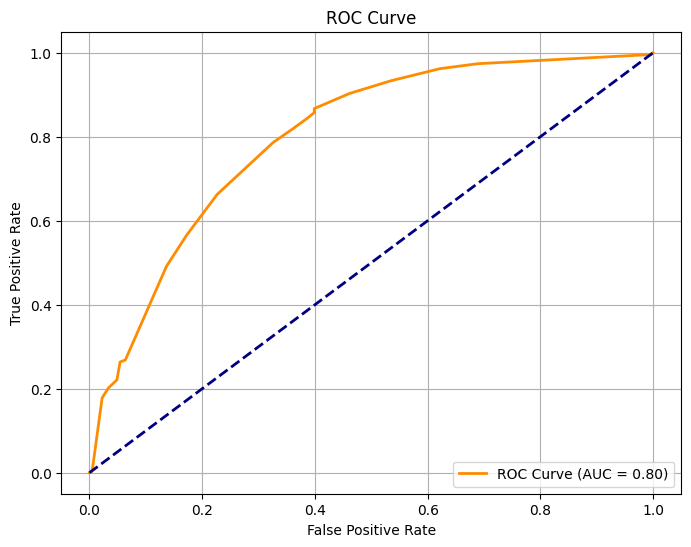

Classes: [0 1]
(array([0, 1]), array([555, 400], dtype=int64))
Confusion Matrix for grid_tree_01:
 [[413 121]
 [142 279]]


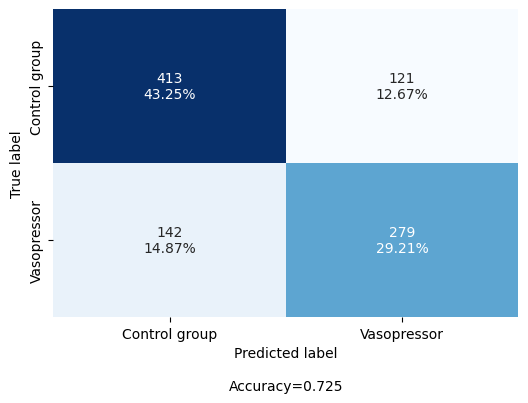

Accuracy: 0.724607329842932
F1 Score for class 1: 0.679658952496955
Sensitivity for class 1: 0.66270783847981
Specificity: 0.7734082397003745


['DTM_GS_01_package.joblib']

In [33]:
## Internal
DT_model = DecisionTreeClassifier(random_state = 48) 
DTM_GS_01 = GridSearchCV(DT_model, 
                          param_grid = parameters, 
                          cv=10, 
                          refit=True)

DTM_GS_01.fit(xd_train_01, yd_train_01)

scores_df_01 = pd.DataFrame(DTM_GS_01.cv_results_)
scores_df_01[['params', 'mean_test_score','rank_test_score', 'split0_test_score', 'split1_test_score','split2_test_score']]


#4.2  최고 성능의 결과값만 보기
print('GridSearchCV 최적 파라미터:', DTM_GS_01.best_params_)
print('GridSearchCV 최고 정확도:{0:.4f}'.format(DTM_GS_01.best_score_))

DTM_GS_01_pred = DTM_GS_01.predict(xd_test_01) 
accuracy = accuracy_score(DTM_GS_01_pred, yd_test_01)  
print('정확도(Accuracy) : %.2f%%'%(accuracy*100))

DTM_GS_01_pred_proba = DTM_GS_01.predict_proba(xd_test_01)[:, 1]  # 양성 클래스(1) 확률
DTM_GS_01_fpr, DTM_GS_01_tpr, DTM_GS_01_thresholds = roc_curve(yd_test_01, DTM_GS_01_pred_proba)
DTM_GS_01_roc_auc = auc(DTM_GS_01_fpr, DTM_GS_01_tpr)
print(DTM_GS_01_roc_auc)
# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(DTM_GS_01_fpr, DTM_GS_01_tpr, label=f'ROC Curve (AUC = {DTM_GS_01_roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

target_names =  ["Control group", "Vasopressor"]
rlt_DTM_GS_01 = evaluate_model_performance(yd_test_01, DTM_GS_01_pred, model_name="grid_tree_01", categories=target_names, positive_class=1, filename = "05_confusion_matri_Tree_case1_internal.png")

# 모델저장하기 
model_package = {
    'model': DTM_GS_01,
    'best_params': DTM_GS_01.best_params_,
    'best_score': DTM_GS_01.best_score_,
    'predictions': DTM_GS_01_pred,
    'pred_proba': DTM_GS_01_pred_proba,
    'roc_auc': DTM_GS_01_roc_auc,
    'fpr': DTM_GS_01_fpr,
    'tpr': DTM_GS_01_tpr,
    'thresholds': DTM_GS_01_thresholds,
    'evaluation_results': rlt_DTM_GS_01,
    'feature_names': xd_train_01.columns.tolist(),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

joblib.dump(model_package, 'DTM_GS_01_package.joblib')

In [ ]:
# # 모델 불러오기 
# loaded_package = joblib.load('DTM_GS_01_package.joblib')
# loaded_model = loaded_package['model']
# # 새로운 예측
# new_predictions = loaded_model.predict(new_data)

0.7658614954448464


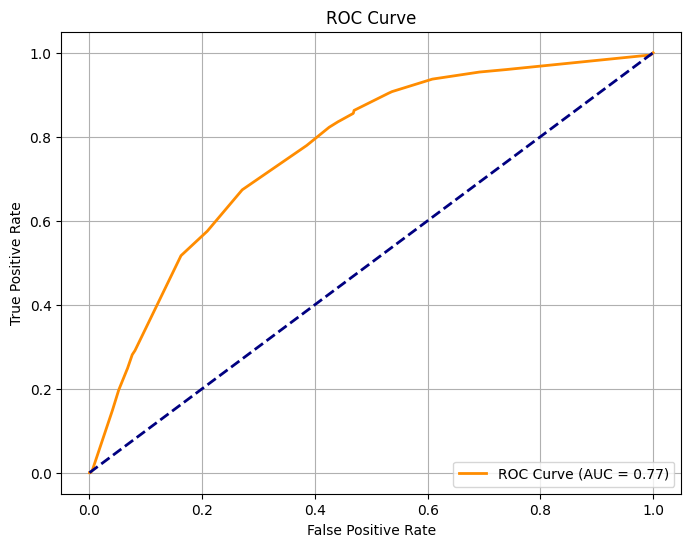

Classes: [0 1]
(array([0, 1]), array([2021, 1604], dtype=int64))
Confusion Matrix for DTM_GS_01:
 [[1517  564]
 [ 504 1040]]


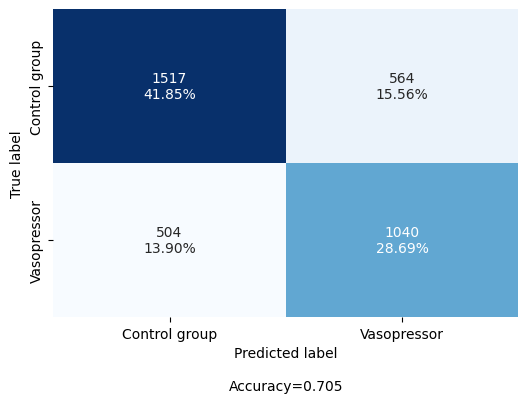

Accuracy: 0.7053793103448276
F1 Score for class 1: 0.6607369758576874
Sensitivity for class 1: 0.6735751295336787
Specificity: 0.7289764536280634


In [38]:
## External 
DTM_GS_01_pred_ext_proba = DTM_GS_01.predict_proba(xd_01_ext)[:, 1]  # 양성 클래스(1) 확률
DTM_GS_01_ext_fpr, DTM_GS_01_ext_tpr, DTM_GS_01_ext_thresholds = roc_curve(y_01_ext, DTM_GS_01_pred_ext_proba)
DTM_GS_01_ext_roc_auc = auc(DTM_GS_01_ext_fpr, DTM_GS_01_ext_tpr)
print(DTM_GS_01_ext_roc_auc)
# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(DTM_GS_01_ext_fpr, DTM_GS_01_ext_tpr, label=f'ROC Curve (AUC = {DTM_GS_01_ext_roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

DTM_GS_01_pred_ext = DTM_GS_01.predict(xd_01_ext) 
target_names =  ["Control group", "Vasopressor"]
rlt_DTM_GS_01_ext = evaluate_model_performance(y_01_ext, DTM_GS_01_pred_ext, model_name="DTM_GS_01", categories=target_names, positive_class=1, filename = "06_confusion_matri_Tree_case1_external.png")

bundletime_fluid_1         0.558241
IVS_MBP                    0.136362
Lactate                    0.116172
IVS_SBP                    0.070238
ArterialPH                 0.017244
buncletime_abx_1           0.015838
bundletime_fluid_2         0.012926
Albumin                    0.011097
CRP                        0.009594
Cr                         0.009060
ANC                        0.008831
IVS_DBP                    0.007970
Neutrophil                 0.006372
IVS_BT                     0.005546
PaCO2                      0.004991
Bilirubin                  0.003833
buncletime_lac_1           0.002892
Ht                         0.002795
TypeInfection_MOSAICS_3    0.000000
TypeInfection_MOSAICS_2    0.000000
dtype: float64


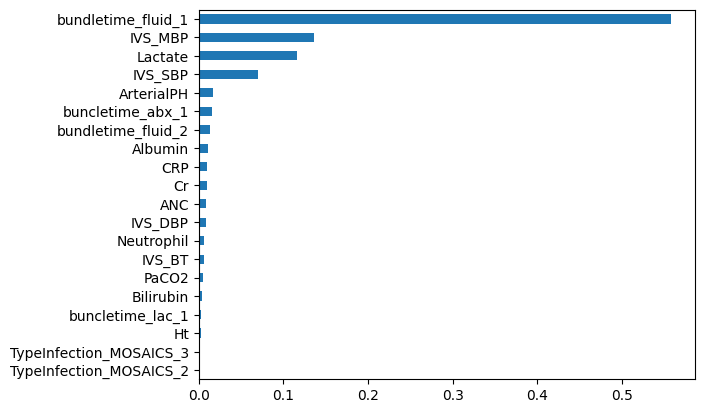

In [39]:
best_model = DTM_GS_01.best_estimator_
best_model_dt_01 = pd.Series(best_model.feature_importances_, xd_train_01.columns)
best_model_dt_01.sort_values(ascending=False)[:20].sort_values(ascending=True).plot.barh();
best_model_dt_01_top20 = best_model_dt_01.sort_values(ascending=False)[:20]
print(best_model_dt_01_top20)
plt.savefig('103_feaure_importance_tree_case1.png', dpi=300, bbox_inches='tight')

#### DT 그리드 서치 Case2

GridSearchCV 최적 파라미터: {'max_depth': 5, 'min_samples_split': 3}
GridSearchCV 최고 정확도:0.6738
정확도(Accuracy) : 65.39%
0.7452989779322574


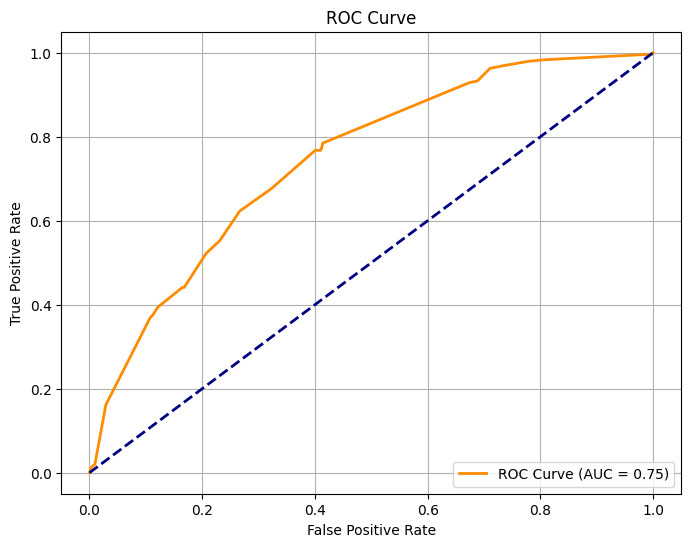

Classes: [0 1]
(array([0, 1]), array([440, 476], dtype=int64))
Confusion Matrix for DTM_GS_02:
 [[371 248]
 [ 69 228]]


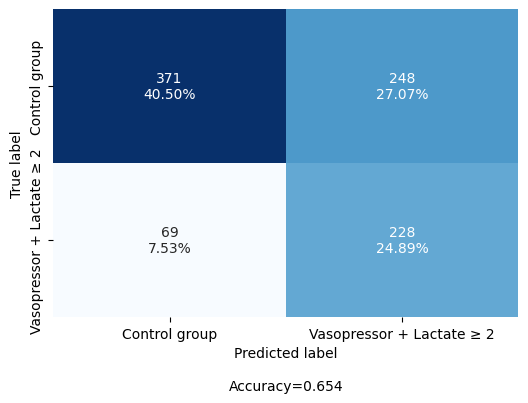

Accuracy: 0.6539301310043668
F1 Score for class 1: 0.5899094437257438
Sensitivity for class 1: 0.7676767676767676
Specificity: 0.5993537964458805


['DTM_GS_02_package.joblib']

In [41]:
DT_model = DecisionTreeClassifier(class_weight = 'balanced', random_state = 48) 
DTM_GS_02 = GridSearchCV(DT_model, 
                          param_grid = parameters, 
                          cv=10, 
                          refit=True)

DTM_GS_02.fit(xd_train_02, yd_train_02)

scores_df_02 = pd.DataFrame(DTM_GS_02.cv_results_)
scores_df_02[['params', 'mean_test_score','rank_test_score', 'split0_test_score', 'split1_test_score','split2_test_score']]


#4.2  최고 성능의 결과값만 보기
print('GridSearchCV 최적 파라미터:', DTM_GS_02.best_params_)
print('GridSearchCV 최고 정확도:{0:.4f}'.format(DTM_GS_02.best_score_))


DTM_GS_02_pred = DTM_GS_02.predict(xd_test_02) 
accuracy = accuracy_score(DTM_GS_02_pred, yd_test_02)  
print('정확도(Accuracy) : %.2f%%'%(accuracy*100))

DTM_GS_02_pred_proba = DTM_GS_02.predict_proba(xd_test_02)[:, 1]  # 양성 클래스(1) 확률
DTM_GS_02_fpr, DTM_GS_02_tpr, DTM_GS_02_thresholds = roc_curve(yd_test_02, DTM_GS_02_pred_proba)
DTM_GS_02_roc_auc = auc(DTM_GS_02_fpr, DTM_GS_02_tpr)
print(DTM_GS_02_roc_auc)
# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(DTM_GS_02_fpr, DTM_GS_02_tpr, label=f'ROC Curve (AUC = {DTM_GS_02_roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

target_names =  ["Control group","Vasopressor + Lactate ≥ 2"]
rlt_DTM_GS_02 = evaluate_model_performance(yd_test_02, DTM_GS_02_pred, model_name="DTM_GS_02", categories=target_names, positive_class=1, filename = "07_confusion_matri_Tree_case2_internal.png")

# 모델저장하기 
model_package = {
    'model': DTM_GS_02,
    'best_params': DTM_GS_02.best_params_,
    'best_score': DTM_GS_02.best_score_,
    'predictions': DTM_GS_02_pred,
    'pred_proba': DTM_GS_02_pred_proba,
    'roc_auc': DTM_GS_02_roc_auc,
    'fpr': DTM_GS_02_fpr,
    'tpr': DTM_GS_02_tpr,
    'thresholds': DTM_GS_02_thresholds,
    'evaluation_results': rlt_DTM_GS_02,
    'feature_names': xd_train_02.columns.tolist(),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

joblib.dump(model_package, 'DTM_GS_02_package.joblib')

In [ ]:
# # 모델 불러오기 
# loaded_package = joblib.load('DTM_GS_02_package.joblib')
# loaded_model = loaded_package['model']
# # 새로운 예측
# new_predictions = loaded_model.predict(new_data)

0.7649659341130715


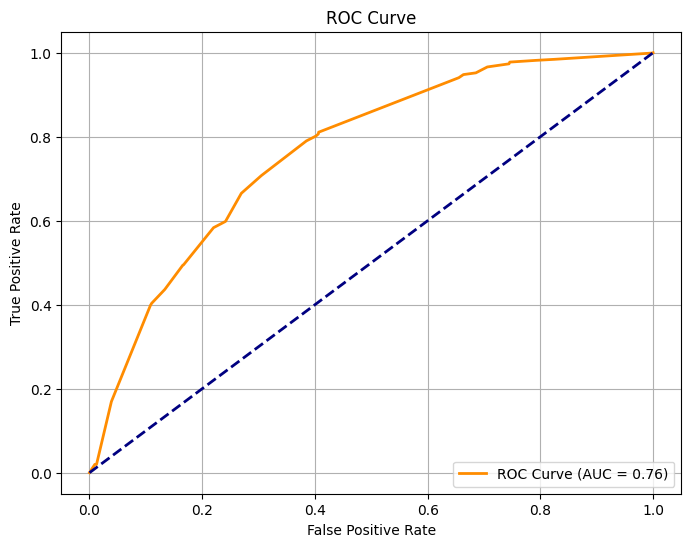

Classes: [0 1]
(array([0, 1]), array([1676, 1846], dtype=int64))
Confusion Matrix for DTM_GS_02:
 [[1422  890]
 [ 254  956]]


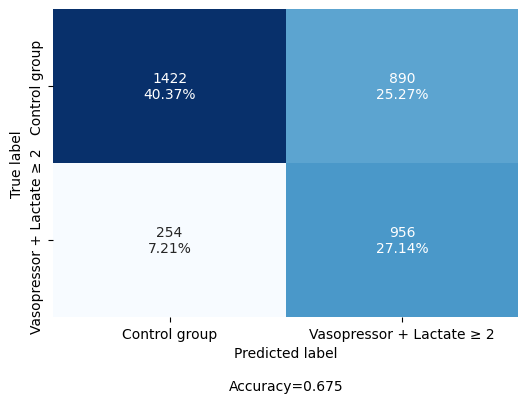

Accuracy: 0.6751845542305508
F1 Score for class 1: 0.6256544502617801
Sensitivity for class 1: 0.7900826446280992
Specificity: 0.6150519031141869


In [42]:
## External 
DTM_GS_02_pred_ext_proba = DTM_GS_02.predict_proba(xd_02_ext)[:, 1]  # 양성 클래스(1) 확률
DTM_GS_02_ext_fpr, DTM_GS_02_ext_tpr, DTM_GS_02_ext_thresholds = roc_curve(y_02_ext, DTM_GS_02_pred_ext_proba)
DTM_GS_02_ext_roc_auc = auc(DTM_GS_02_ext_fpr, DTM_GS_02_ext_tpr)
print(DTM_GS_02_ext_roc_auc)
# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(DTM_GS_02_ext_fpr, DTM_GS_02_ext_tpr, label=f'ROC Curve (AUC = {DTM_GS_02_ext_roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

DTM_GS_02_pred_ext = DTM_GS_02.predict(xd_02_ext) 
target_names = ["Control group","Vasopressor + Lactate ≥ 2"]
rlt_LRM_01_ext = evaluate_model_performance(y_02_ext, DTM_GS_02_pred_ext, model_name="DTM_GS_02", categories=target_names, positive_class=1,filename = "08_confusion_matri_Tree_case2_external.png")

bundletime_fluid_1    0.518919
Bicarbonate           0.144698
IVS_SBP               0.136077
INR                   0.072626
Neutrophil            0.017816
IVS_MBP               0.013476
IVS_HR                0.012751
buncletime_abx_1      0.011486
ArterialPH            0.009965
IVS_RR                0.009066
bundletime_fluid_2    0.008133
Na                    0.007904
BUN                   0.006064
TroponinIT            0.005680
ANC                   0.005499
ALT                   0.005307
Cr                    0.004892
Hct                   0.004538
Albumin               0.002633
Bilirubin             0.002470
dtype: float64


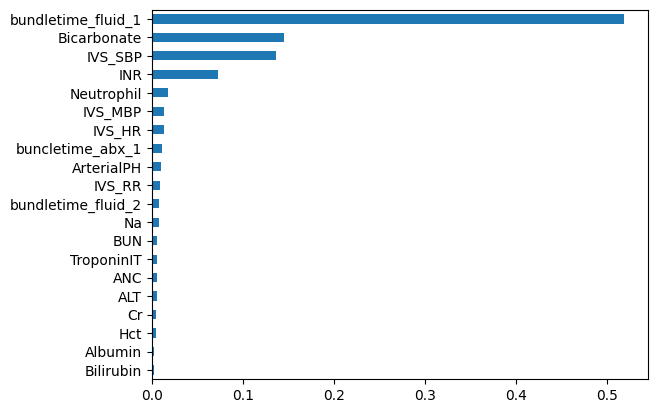

In [43]:
best_model = DTM_GS_02.best_estimator_
best_model_dt_02 = pd.Series(best_model.feature_importances_, xd_train_02.columns)
best_model_dt_02.sort_values(ascending=False)[:20].sort_values(ascending=True).plot.barh();
best_model_dt_02_top20 = best_model_dt_02.sort_values(ascending=False)[:20]
print(best_model_dt_02_top20)
plt.savefig('104_feaure_importance_tree_case2.png', dpi=300, bbox_inches='tight')

### Random Forest 

#### RF그리드 서치 Case1

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best 하이퍼 파리미터 : {'n_estimators': 200, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 25, 'criterion': 'entropy'}
best 하이퍼 파리미터정확도 :  0.73
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       534
           1       0.72      0.71      0.72       421

    accuracy                           0.75       955
   macro avg       0.75      0.75      0.75       955
weighted avg       0.75      0.75      0.75       955


Random Search 정확도:  0.7518324607329843
0.8442401273942014


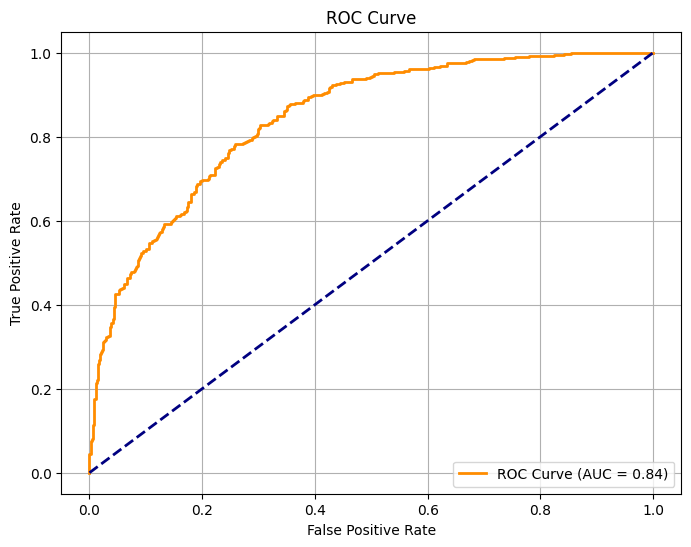

Classes: [0 1]
(array([0, 1]), array([543, 412], dtype=int64))
Confusion Matrix for rf_gs_01:
 [[420 114]
 [123 298]]


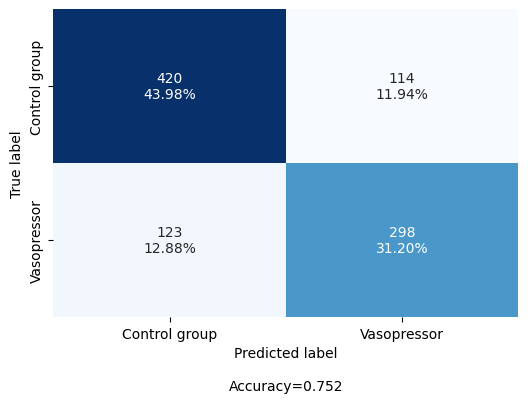

Accuracy: 0.7518324607329843
F1 Score for class 1: 0.7154861944777912
Sensitivity for class 1: 0.7078384798099763
Specificity: 0.7865168539325843


['RF_random_01_package.joblib']

In [44]:
# 그리드 서치 
rf_model_01 = RandomForestClassifier(random_state = 48)

# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의
parameters = {'criterion': ['entropy', 'gini'],
               'max_depth': [25],
               'max_features': [ 'sqrt'],
               'min_samples_leaf': [4, 6, 8, 10, 12, 14,16,18],
               'min_samples_split': [5, 7, 9, 11, 13, 15,17,19],
               'n_estimators': [200]}


random_Random_01 = RandomizedSearchCV(estimator = rf_model_01, 
                           param_distributions = parameters, 
                           cv = 10, 
                           verbose= 1, 
                           random_state= 101, 
                           n_iter = 10, 
                           n_jobs = -1)

random_Random_01.fit(xd_train_01,yd_train_01)

#print(rf_hyper_parameter_tuner.best_params_)
#print(rf_hyper_parameter_tuner.best_params_)

print('best 하이퍼 파리미터 : {0}'.format (random_Random_01.best_params_))
print('best 하이퍼 파리미터정확도 : {0: .2f}'.format (random_Random_01.best_score_))

rf_gs_01_pred = random_Random_01.best_estimator_.predict(xd_test_01)
print(classification_report(yd_test_01, rf_gs_01_pred))
print("\nRandom Search 정확도: ", accuracy_score(yd_test_01, rf_gs_01_pred))

# ROC Curve 및 AUC 계산
rf_gs_01_pred_proba = random_Random_01.best_estimator_.predict_proba(xd_test_01)[:, 1]  # 양성 클래스 확률 추출
rf_gs_01_fpr,rf_gs_01_tpr,rf_gs_01_thresholds = roc_curve(yd_test_01, rf_gs_01_pred_proba)
rf_gs_01_roc_auc = auc(rf_gs_01_fpr, rf_gs_01_tpr)
print(rf_gs_01_roc_auc)
# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(rf_gs_01_fpr, rf_gs_01_tpr, label=f'ROC Curve (AUC = {rf_gs_01_roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

target_names =  ["Control group", "Vasopressor"]
rlt_rf_gs_01 = evaluate_model_performance(yd_test_01, rf_gs_01_pred, model_name="rf_gs_01", categories=target_names, positive_class=1, filename = "09_confusion_matri_RF_case1_internal.png")


model_package = {
    'model': random_Random_01,
    'best_estimator': random_Random_01.best_estimator_,
    'best_params': random_Random_01.best_params_,
    'best_score': random_Random_01.best_score_,
    'predictions': rf_gs_01_pred,
    'pred_proba': rf_gs_01_pred_proba,
    'roc_auc': rf_gs_01_roc_auc,
    'fpr': rf_gs_01_fpr,
    'tpr': rf_gs_01_tpr,
    'thresholds': rf_gs_01_thresholds,
    'evaluation_results': rlt_rf_gs_01,
    'feature_names': xd_train_01.columns.tolist(),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

joblib.dump(model_package, 'RF_random_01_package.joblib')

In [ ]:
# # 모델불러오기
# loaded_package = joblib.load('RF_random_01_package.joblib')
# loaded_model = loaded_package['model']
# loaded_best_estimator = loaded_package['best_estimator']

# # 새로운 예측
# new_predictions = loaded_best_estimator.predict(new_data)

0.819588716564625


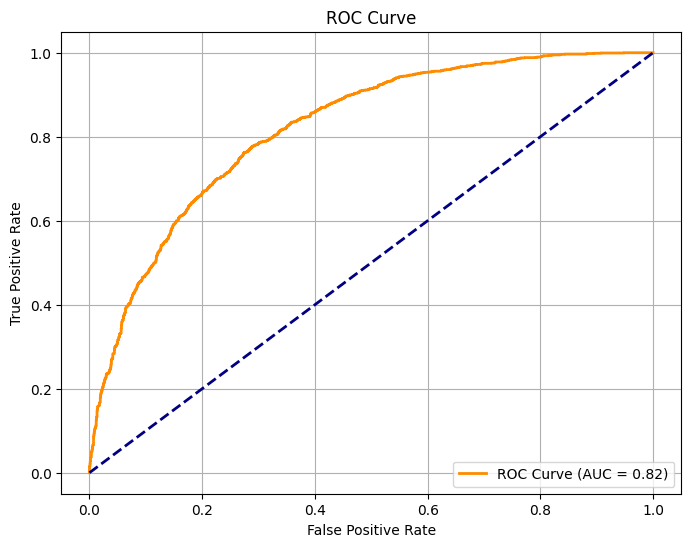

Classes: [0 1]
(array([0, 1]), array([1965, 1660], dtype=int64))
Confusion Matrix for rf_gs_01:
 [[1549  532]
 [ 416 1128]]


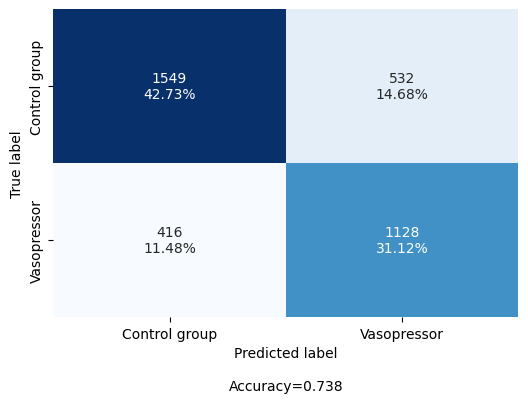

Accuracy: 0.7384827586206897
F1 Score for class 1: 0.704119850187266
Sensitivity for class 1: 0.7305699481865285
Specificity: 0.7443536761172513


In [45]:
# External 
rf_gs_01_pred_ext_proba = random_Random_01.best_estimator_.predict_proba(xd_01_ext)[:, 1]  # 양성 클래스 확률 추출
rf_gs_01_ext_fpr,rf_gs_01_ext_tpr,rf_gs_01_ext_thresholds = roc_curve(y_01_ext, rf_gs_01_pred_ext_proba)
rf_gs_01_ext_roc_auc = auc(rf_gs_01_ext_fpr, rf_gs_01_ext_tpr)
print(rf_gs_01_ext_roc_auc)
# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(rf_gs_01_ext_fpr, rf_gs_01_ext_tpr, label=f'ROC Curve (AUC = {rf_gs_01_ext_roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

rf_gs_01_pred_ext = random_Random_01.best_estimator_.predict(xd_01_ext)
target_names =  ["Control group", "Vasopressor"]
rlt_LRM_01_ext = evaluate_model_performance(y_01_ext, rf_gs_01_pred_ext, model_name="rf_gs_01", categories=target_names, positive_class=1, filename = "10_confusion_matri_RF_case1_external.png")

IVS_SBP               0.058097
bundletime_fluid_1    0.054604
bundletime_fluid_2    0.053314
IVS_MBP               0.041442
Lactate               0.041007
IVS_DBP               0.038292
ArterialPH            0.029434
Bicarbonate           0.028254
INR                   0.025800
Cr                    0.024288
Neutrophil            0.022405
WBC                   0.021466
ANC                   0.021437
Albumin               0.021423
BUN                   0.020922
CRP                   0.020584
PaCO2                 0.020357
Glucose               0.019923
Plt                   0.019881
TroponinIT            0.019226
dtype: float64


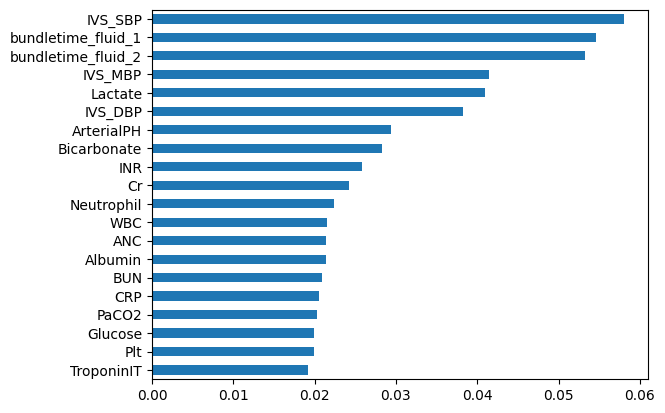

In [46]:
# RF
best_model = random_Random_01.best_estimator_
best_model_rf_01 = pd.Series(best_model.feature_importances_, xd_train_01.columns)
best_model_rf_01.sort_values(ascending=False)[:20].sort_values(ascending=True).plot.barh();
best_model_rf_01_top20 = best_model_rf_01.sort_values(ascending=False)[:20]
print(best_model_rf_01_top20)
plt.savefig('105_feaure_importance_RF_case1.png', dpi=300, bbox_inches='tight')

#### RF그리드 서치 Case2

In [ ]:
# 그리드 서치 
rf_model_02 = RandomForestClassifier(random_state = 2025) #48

# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의
parameters = {'criterion': ['entropy', 'gini'],
               'max_depth': [50],
               'max_features': ['sqrt'],
               'min_samples_leaf': [4, 6, 8, 10, 12, 14,16,18,20,22],
               'min_samples_split': [5, 7, 9, 11, 13, 15,17,19,21],
               'class_weight': ['balanced', None],
               'n_estimators': [300]}


random_Random_02 = RandomizedSearchCV(estimator = rf_model_02, 
                           param_distributions = parameters, 
                           cv = 10, 
                           verbose= 1, 
                           random_state= 2025, 
                           n_iter = 10, 
                           n_jobs = -1,
                           scoring='recall')

random_Random_02.fit(xd_train_02,yd_train_02)

#print(rf_hyper_parameter_tuner.best_params_)
#print(rf_hyper_parameter_tuner.best_params_)

print('best 하이퍼 파리미터 : {0}'.format (random_Random_02.best_params_))
print('best 하이퍼 파리미터정확도 : {0: .2f}'.format (random_Random_02.best_score_))

rf_gs_02_pred = random_Random_02.best_estimator_.predict(xd_test_02)
print(classification_report(yd_test_02, rf_gs_02_pred))
print("\nRandom Search 정확도: ", accuracy_score(yd_test_02, rf_gs_02_pred))

# ROC Curve 및 AUC 계산
rf_gs_02_pred_proba = random_Random_02.best_estimator_.predict_proba(xd_test_02)[:, 1]  # 양성 클래스 확률 추출
rf_gs_02_fpr,rf_gs_02_tpr,rf_gs_02_thresholds = roc_curve(yd_test_02, rf_gs_02_pred_proba)
rf_gs_02_roc_auc = auc(rf_gs_02_fpr, rf_gs_02_tpr)
print(rf_gs_02_roc_auc)
# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(rf_gs_02_fpr, rf_gs_02_tpr, label=f'ROC Curve (AUC = {rf_gs_02_roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# target_names = ["Control group","Vasopressor + Lactate ≥ 2"]
rlt_rf_gs_02 = evaluate_model_performance(yd_test_02, rf_gs_02_pred, model_name="rf_gs_02", categories=target_names, positive_class=1, filename = "11_confusion_matri_RF_case2_internal.png")

model_package = {
    'model': random_Random_02,
    'best_estimator': random_Random_02.best_estimator_,
    'best_params': random_Random_02.best_params_,
    'best_score': random_Random_02.best_score_,
    'predictions': rf_gs_02_pred,
    'pred_proba': rf_gs_02_pred_proba,
    'roc_auc': rf_gs_02_roc_auc,
    'fpr': rf_gs_02_fpr,
    'tpr': rf_gs_02_tpr,
    'thresholds': rf_gs_02_thresholds,
    'evaluation_results': rlt_rf_gs_02,
    'feature_names': xd_train_02.columns.tolist(),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

joblib.dump(model_package, 'RF_random_02_package.joblib')

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
# #모델불러오기
# loaded_package = joblib.load('RF_random_02_package.joblib')
# loaded_model = loaded_package['model']
# loaded_best_estimator = loaded_package['best_estimator']

# # 새로운 예측
# new_predictions = loaded_best_estimator.predict(new_data)

In [ ]:
# External 
rf_gs_02_pred_ext_proba = random_Random_02.predict_proba(xd_02_ext)[:, 1]  # 양성 클래스 확률 추출
rf_gs_02_ext_fpr,rf_gs_02_ext_tpr,rf_gs_02_ext_thresholds = roc_curve(y_02_ext, rf_gs_02_pred_ext_proba)
rf_gs_02_ext_roc_auc = auc(rf_gs_02_ext_fpr, rf_gs_02_ext_tpr)
print(rf_gs_02_ext_roc_auc)
# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(rf_gs_02_ext_fpr, rf_gs_02_ext_tpr, label=f'ROC Curve (AUC = {rf_gs_02_ext_roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

rf_gs_02_pred_ext = random_Random_02.best_estimator_.predict(xd_02_ext)
target_names = ["Control group","Vasopressor + Lactate ≥ 2"]
rlt_rf_gs_02_ext = evaluate_model_performance(y_02_ext, rf_gs_02_pred_ext, model_name="rf_gs_02", categories=target_names, positive_class=1)

In [ ]:
# RF
best_model = random_Random_02.best_estimator_
best_model_rf_02 = pd.Series(best_model.feature_importances_, xd_train_02.columns)
best_model_rf_02.sort_values(ascending=False)[:20].sort_values(ascending=True).plot.barh();
best_model_rf_02_top20 = best_model_rf_02.sort_values(ascending=False)[:20]
print(best_model_rf_02_top20)
plt.savefig('106_feaure_importance_RF_case2.png', dpi=300, bbox_inches='tight')

### XGBoost

#### XGBoost Case1

In [ ]:
# 2. 객체 생성하기 model = XGBClassifier( 하이퍼 파라미터~)
xgb_model_01 = XGBClassifier(
    learning_rate =0.1, # 학습 속도
    n_estimators=1000,  #
    max_depth=20,
    min_child_weight=3,
    gamma=0,
    seed=27,
    early_stopping_rounds = 400,
    eval_metric = 'logloss'
)

# 모델 적합(학습)
xgb_model_01.fit(xd_train_01, yd_train_01,               
              eval_set = [(xd_valid_01, yd_valid_01)])

# predict 수행
XGB_01_pred = xgb_model_01.predict(xd_test_01)
# y_pred_probability = xgb_model.predict_proba(xd_test_01)[:,1]  # ROC 커브

accuracy = accuracy_score(yd_test_01, XGB_01_pred)      # 4. 모델 평가            
print('정확도(Accuracy) : %.2f%%'%(accuracy*100))

# xgb_model_01.get_booster().get_score(importance_type='weight')
pd.DataFrame( xgb_model_01.get_booster().get_score(importance_type='weight').items(), columns=['feature','importance']).sort_values('importance', ascending=False).head(20)

# 변수 중요도 그림 작성
from xgboost import plot_importance
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 5, 5
# xgb_model.get_booster().feature_names = xd_01.columns
plot_importance(xgb_model_01,  max_num_features=20 )
# plt.yticks(fontsize=15)
plt.show()

XGB_01_pred_proba = xgb_model_01.predict_proba(xd_test_01)[:, 1]  # 양성 클래스(1) 확률

# ROC Curve 및 AUC 계산
XGB_01_fpr, XGB_01_tpr, XGB_01_thresholds = roc_curve(yd_test_01, XGB_01_pred_proba)
XGB_01_roc_auc = auc(XGB_01_fpr, XGB_01_tpr)
print(XGB_01_roc_auc)
# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(XGB_01_fpr, XGB_01_tpr, label=f'ROC Curve (AUC = {XGB_01_roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


target_names =  ["Control group", "Vasopressor"]
rlt_XGB_01 = evaluate_model_performance(yd_test_01, XGB_01_pred, model_name="xgb_model_01", categories=target_names, positive_class=1, filename = "13_confusion_matri_XGBoost_case1_internal.png")

# 모델 저장하기 
model_package = {
    'model': xgb_model_01,
    'predictions': XGB_01_pred,
    'pred_proba': XGB_01_pred_proba,
    'roc_auc': XGB_01_roc_auc,
    'fpr': XGB_01_fpr,
    'tpr': XGB_01_tpr,
    'thresholds': XGB_01_thresholds,
    'evaluation_results': rlt_XGB_01,
    'feature_importance': xgb_model_01.get_booster().get_score(importance_type='weight'),
    'feature_names': xd_train_01.columns.tolist(),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

joblib.dump(model_package, 'XGB_01_package.joblib')

In [ ]:
# # 모델 불러오기 
# loaded_package = joblib.load('XGB_02_package.joblib')
# loaded_model = loaded_package['model']
# loaded_feature_importance = loaded_package['feature_importance']

# # 새로운 예측
# new_predictions = loaded_model.predict(new_data)

In [ ]:
XGB_01_pred_ext_proba = xgb_model_01.predict_proba(xd_01_ext)[:, 1]  # 양성 클래스(1) 확률

# ROC Curve 및 AUC 계산
XGB_01_ext_fpr, XGB_01_ext_tpr, XGB_01_ext_thresholds = roc_curve(y_01_ext, XGB_01_pred_ext_proba)
XGB_01_ext_roc_auc = auc(XGB_01_ext_fpr, XGB_01_ext_tpr)
print(XGB_01_ext_roc_auc)
# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(XGB_01_ext_fpr, XGB_01_ext_tpr, label=f'ROC Curve (AUC = {XGB_01_ext_roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

XGB_01_pred_ext = xgb_model_01.predict(xd_01_ext)
target_names =  ["Control group", "Vasopressor"]
rlt_XGB_01_ext = evaluate_model_performance(y_01_ext, XGB_01_pred_ext, model_name="xgb_model_01", categories=target_names, positive_class=1, filename ="14_confusion_matri_XGBoost_case1_external.png")

In [ ]:
# explainer = shap.Explainer(xgb_model_01, xd_train_01.astype(float))
# shap_values = explainer(xd_test_01)
# top_n = 20
# plt.figure(figsize=(10, 6))
# shap.summary_plot(shap_values, xd_test_01, plot_type="bar", show=False, max_display=top_n)
# plt.show()

In [ ]:
explainer = shap.Explainer(xgb_model_01, xd_train_01.astype(float))
shap_values = explainer(xd_test_01)
top_n = 20
# ===== summary plot 이미지를 임시 버퍼에 저장 =====
plt.figure(figsize=(6, 6))
shap.summary_plot(shap_values, xd_test_01, plot_type="bar", show=False, max_display=top_n)
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', dpi=200)
plt.close()
buf.seek(0)
img0 = Image.open(buf)

plt.figure(figsize=(6, 6))
shap.summary_plot(shap_values, xd_test_01, show=False, max_display=top_n)
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', dpi=200)
plt.close()
buf.seek(0)
img1 = Image.open(buf)


fig, ax = plt.subplots(1, 2, figsize=(16, 12),
                       gridspec_kw={'width_ratios': [1,1 ]})

# ===== 왼쪽 Bar Plot =====
ax[0].imshow(img0)
ax[0].axis('off')

# ===== 오른쪽 summary plot =====
ax[1].imshow(img1)
ax[1].axis('off')
# ax[1].set_title('Local Explanation Summary', fontsize=13, pad=15)
plt.savefig(fname = '107_feaure_importance_XGBoost_case1.png',format='png', bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()


In [ ]:
# SHAP summary plot은 직접 Figure에 그리는 방식이 아니므로 임시 버퍼에 저장 후 이미지로 읽는 방식 사용
def get_shap_plot_image(shap_values, features, plot_type="dot", figsize=(6,6), dpi=200, top_n=20):
    buf = io.BytesIO()
    plt.figure(figsize=figsize)
    shap.summary_plot(shap_values, features, plot_type=plot_type, show=False, max_display=top_n)
    plt.savefig(buf, format='png', bbox_inches='tight', dpi=dpi)
    plt.close()
    buf.seek(0)
    return Image.open(buf)

# SHAP 플롯 이미지 생성
img_bar = get_shap_plot_image(shap_values, xd_test_01, plot_type="bar", top_n=top_n)
img_dot = get_shap_plot_image(shap_values, xd_test_01, plot_type="dot", top_n=top_n)

# 시각화: 두 이미지를 하나의 figure에 나란히 배치
fig, ax = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1]})

ax[0].imshow(img_bar)
ax[0].axis('off')
# ax[0].set_title("Feature Importance (Bar)", fontsize=14)

ax[1].imshow(img_dot)
ax[1].axis('off')
# ax[1].set_title("Summary Plot (Dot)", fontsize=14)

plt.tight_layout()
plt.savefig('107_feature_importance_XGBoost_case1.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


#### XGBoost Case2

In [ ]:
# from sklearn.utils.class_weight import compute_sample_weight
# 2. 객체 생성하기 model = XGBClassifier( 하이퍼 파라미터~)
xgb_model_02 = XGBClassifier(
    learning_rate =0.1, # 학습 속도
    n_estimators=1000,  #
    max_depth=20,
    min_child_weight=3,
    gamma=0,
    seed=27,
    early_stopping_rounds = 500, 
    eval_metric = 'logloss'
)

# 모델 적합(학습)
xgb_model_02.fit(xd_train_02, yd_train_02, 
              
              eval_set = [(xd_valid_02, yd_valid_02)],
                sample_weight=compute_sample_weight("balanced", yd_train_02))

# predict 수행
XGB_02_pred = xgb_model_02.predict(xd_test_02)
# y_pred_probability = xgb_model.predict_proba(xd_test_01)[:,1]  # ROC 커브

# xgb_model_01.get_booster().get_score(importance_type='weight')
pd.DataFrame( xgb_model_02.get_booster().get_score(importance_type='weight').items(), columns=['feature','importance']).sort_values('importance', ascending=False).head(20)

# 변수 중요도 그림 작성
rcParams['figure.figsize'] = 5, 5
# xgb_model.get_booster().feature_names = xd_01.columns
plot_importance(xgb_model_02,  max_num_features=20 )
# plt.yticks(fontsize=15)
plt.show()

XGB_02_pred_proba = xgb_model_02.predict_proba(xd_test_02)[:, 1]  # 양성 클래스(1) 확률

# ROC Curve 및 AUC 계산
XGB_02_fpr, XGB_02_tpr, XGB_02_thresholds = roc_curve(yd_test_02, XGB_02_pred_proba)
XGB_02_roc_auc = auc(XGB_02_fpr, XGB_02_tpr)
print(XGB_02_roc_auc)
# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(XGB_02_fpr, XGB_02_tpr, label=f'ROC Curve (AUC = {XGB_02_roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

target_names = ["Control group","Vasopressor + Lactate ≥ 2"]
rlt_XGB_02 = evaluate_model_performance(yd_test_02, XGB_02_pred, model_name="xgb_model_02", categories=target_names, positive_class=1,filename = "15_confusion_matri_XGBoost_case2_internal.png")

# 모델 저장하기 
model_package = {
    'model': xgb_model_02,
    'predictions': XGB_02_pred,
    'pred_proba': XGB_02_pred_proba,
    'roc_auc': XGB_02_roc_auc,
    'fpr': XGB_02_fpr,
    'tpr': XGB_02_tpr,
    'thresholds': XGB_02_thresholds,
    'evaluation_results': rlt_XGB_02,
    'feature_importance': xgb_model_02.get_booster().get_score(importance_type='weight'),
    'feature_names': xd_train_02.columns.tolist(),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

joblib.dump(model_package, 'XGB_02_package.joblib')

In [ ]:
XGB_02_pred_ext_proba = xgb_model_02.predict_proba(xd_02_ext)[:, 1]  # 양성 클래스(1) 확률

# ROC Curve 및 AUC 계산
XGB_02_ext_fpr, XGB_02_ext_tpr, XGB_02_ext_thresholds = roc_curve(y_02_ext, XGB_02_pred_ext_proba)
XGB_02_ext_roc_auc = auc(XGB_02_ext_fpr, XGB_02_ext_tpr)
print(XGB_02_ext_roc_auc)
# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(XGB_02_ext_fpr, XGB_02_ext_tpr, label=f'ROC Curve (AUC = {XGB_02_ext_roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
XGB_02_pred_ext = xgb_model_02.predict(xd_02_ext)
target_names =  ["Control group","Vasopressor + Lactate ≥ 2"]
rlt_XGB_02_ext = evaluate_model_performance(y_02_ext, XGB_02_pred_ext, model_name="xgb_model_02", categories=target_names, positive_class=1, filename ="16_confusion_matri_XGBoost_case2_external.png")

In [ ]:
explainer = shap.Explainer(xgb_model_02, xd_train_02.astype(float))
shap_values = explainer(xd_test_02)
top_n = 20
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, xd_test_02, plot_type="bar", show=False, max_display=top_n)
plt.show()

In [ ]:
# ===== summary plot 이미지를 임시 버퍼에 저장 =====
plt.figure(figsize=(6, 6))
shap.summary_plot(shap_values, xd_test_02, plot_type="bar", show=False, max_display=top_n)
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', dpi=200)
plt.close()
buf.seek(0)
img0 = Image.open(buf)

plt.figure(figsize=(6, 6))
shap.summary_plot(shap_values, xd_test_02, show=False, max_display=top_n)
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', dpi=200)
plt.close()
buf.seek(0)
img1 = Image.open(buf)


fig, ax = plt.subplots(1, 2, figsize=(16, 12),
                       gridspec_kw={'width_ratios': [1,1 ]})

# ===== 왼쪽 Bar Plot =====
ax[0].imshow(img0)
ax[0].axis('off')

# ===== 오른쪽 summary plot =====
ax[1].imshow(img1)
ax[1].axis('off')
# ax[1].set_title('Local Explanation Summary', fontsize=13, pad=15)
plt.savefig(fname = '108_feaure_importance_XGBoost_case2.png',format='png', bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()


## AUC 그리기

### AUC Case1

In [ ]:
import matplotlib.pyplot as plt

# 전체 그래프 크기 설정
plt.figure(figsize=(16, 8))  # 가로 16, 세로 8 크기

# 첫 번째 그래프: 1~4번 모델의 ROC Curve
plt.subplot(1, 2, 1)  # 1줄 2칸 중 첫 번째
plt.plot(LRM_01_fpr, LRM_01_tpr, label=f'Logistic regression (AUC = {LRM_01_roc_auc:.2f})', color='steelblue')
plt.plot(DTM_GS_01_fpr, DTM_GS_01_tpr, label=f'Decition Tree (AUC = {DTM_GS_01_roc_auc:.2f})', color='orange', linestyle=':')
plt.plot(rf_gs_01_fpr, rf_gs_01_tpr, label=f'Random Forest (AUC = {rf_gs_01_roc_auc:.2f})', color='darkgreen', linestyle='--')
plt.plot(XGB_01_fpr, XGB_01_tpr, label=f'XGBoost (AUC = {XGB_01_roc_auc:.2f})', color='Maroon', linestyle='-.')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(a) Derivation dataset')
plt.legend(loc='lower right')
plt.grid()

# 두 번째 그래프: 5~8번 모델의 ROC Curve
plt.subplot(1, 2, 2)  # 1줄 2칸 중 두 번째
plt.plot(LRM_01_ext_fpr, LRM_01_ext_tpr, label=f'Logsitic regression (AUC = {LRM_01_ext_roc_auc:.2f})', color='steelblue')
plt.plot(DTM_GS_01_ext_fpr, DTM_GS_01_ext_tpr, label=f'Decision tree (AUC = {DTM_GS_01_ext_roc_auc:.2f})', color='orange', linestyle=':')
plt.plot(rf_gs_01_ext_fpr, rf_gs_01_ext_tpr, label=f'Random forest (AUC = {rf_gs_01_ext_roc_auc:.2f})', color='darkgreen', linestyle='--')
plt.plot(XGB_01_ext_fpr, XGB_01_ext_tpr, label=f'XGBoost (AUC = {XGB_01_ext_roc_auc:.2f})', color='Maroon', linestyle='-.')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(b) External validation dataset')
plt.legend(loc='lower right')
plt.grid()

# 전체 그래프 간 간격 조정
plt.tight_layout()

# 그래프 출력
plt.savefig('roc_curve_models_01.png', format='png', dpi=300)  # PNG 형식으로 저장, 해상도 300dpi

# 파일 저장 후 그래프 표시
plt.show()


### AUC Case2

In [ ]:
# 전체 그래프 크기 설정
plt.figure(figsize=(16, 8))  # 가로 16, 세로 8 크기

# 첫 번째 그래프: 1~4번 모델의 ROC Curve
plt.subplot(1, 2, 1)  # 1줄 2칸 중 첫 번째
plt.plot(LRM_02_fpr, LRM_02_tpr, label=f'Logistic regression (AUC = {LRM_02_roc_auc:.2f})', color='steelblue')
plt.plot(DTM_GS_02_fpr, DTM_GS_02_tpr, label=f'Decition Tree (AUC = {DTM_GS_02_roc_auc:.2f})', color='orange', linestyle=':')
plt.plot(rf_gs_02_fpr, rf_gs_02_tpr, label=f'Random Forest (AUC = {rf_gs_02_roc_auc:.2f})', color='darkgreen', linestyle='--')
plt.plot(XGB_02_fpr, XGB_02_tpr, label=f'XGBoost (AUC = {XGB_02_roc_auc:.2f})', color='Maroon', linestyle='-.')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(a) Derivation dataset')
plt.legend(loc='lower right')
plt.grid()

# 두 번째 그래프: 5~8번 모델의 ROC Curve
plt.subplot(1, 2, 2)  # 1줄 2칸 중 두 번째
plt.plot(LRM_02_ext_fpr, LRM_02_ext_tpr, label=f'Logsitic regression (AUC = {LRM_02_ext_roc_auc:.2f})', color='steelblue')
plt.plot(DTM_GS_02_ext_fpr, DTM_GS_02_ext_tpr, label=f'Decision tree (AUC = {DTM_GS_02_ext_roc_auc:.2f})', color='orange', linestyle=':')
plt.plot(rf_gs_02_ext_fpr, rf_gs_02_ext_tpr, label=f'Random forest (AUC = {rf_gs_02_ext_roc_auc:.2f})', color='darkgreen', linestyle='--')
plt.plot(XGB_02_ext_fpr, XGB_02_ext_tpr, label=f'XGBoost (AUC = {XGB_02_ext_roc_auc:.2f})', color='Maroon', linestyle='-.')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(b) External validation dataset')
plt.legend(loc='lower right')
plt.grid()

# 전체 그래프 간 간격 조정
plt.tight_layout()

# 그래프 출력
plt.savefig('roc_curve_models_02.png', format='png', dpi=300)  # PNG 형식으로 저장, 해상도 300dpi

# 파일 저장 후 그래프 표시
plt.show()

### 논문 삽입 그림 그리기

#### confusion Matrix 

In [ ]:
# 불러올 이미지 파일 경로 (예시)
image_files = [
    './confusion matrix/01_confusion_matrix_Logistic_case1_internal.png',
    './confusion matrix/05_confusion_matri_Tree_case1_internal.png',
    './confusion matrix/09_confusion_matri_RF_case1_internal.png',
    './confusion matrix/13_confusion_matri_XGBoost_case1_internal.png',
    
    './confusion matrix/02_confusion_matrix_Logistic_case1_external.png',
    './confusion matrix/06_confusion_matri_Tree_case1_external.png',
    './confusion matrix/10_confusion_matri_RF_case1_external.png',
    './confusion matrix/14_confusion_matri_XGBoost_case1_external.png',

    './confusion matrix/03_confusion_matrix_Logistic_case2_internal.png',
    './confusion matrix/07_confusion_matri_Tree_case2_internal.png',
    './confusion matrix/11_confusion_matri_RF_case2_internal.png',
    './confusion matrix/15_confusion_matri_XGBoost_case2_internal.png',

    './confusion matrix/04_confusion_matrix_Logistic_case2_external.png',
    './confusion matrix/08_confusion_matri_Tree_case2_external.png',
    './confusion matrix/12_confusion_matri_RF_case2_external.png',
    './confusion matrix/16_confusion_matri_XGBoost_case2_external.png'
]

# 각 그림의 소제목
titles = ['Logistic regression', 'Decision tree', 'Random forest', 'XGBoost']

# 전체 그림 제목
row_labels = ['(a)', '(b)', '(c)', '(d)']

# ===== 전체 Figure 생성 =====
fig, axes = plt.subplots(4, 4, figsize=(20, 16))  # 가로 넓게

for row in range(4):
    for col in range(4):
        idx = row * 4 + col
        img = mpimg.imread(image_files[idx])
        ax = axes[row, col]
        ax.imshow(img)
        ax.axis('off')
        # 첫 번째 줄만 title 표시
        if row == 0:
            ax.set_title(titles[idx], fontsize=14, pad=6, fontweight='bold')

    # 행 왼쪽에 (A), (B), (C), (D) 표시
    axes[row, 0].text(0.05, 0.9, row_labels[row],
                      transform=axes[row, 0].transAxes,
                      fontsize=12, fontweight='bold', va='bottom')

# 전체 제목
fig.suptitle('Comparison of Model Results', fontsize=18, fontweight='bold', y=0.92)

# 레이아웃 정리
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig('./confusion matrix/00_confusion_matrix_all.png', format='png', dpi=300) 
plt.show()


#### Feature Importance shap

In [ ]:
image_files = [
    './confusion matrix/101_feaure_importance_logistic_case1.png',
    './confusion matrix/107_feaure_importance_XGBoost_case1.png',
    './confusion matrix/102_feaure_importance_logistic_case2.png',
    './confusion matrix/108_feaure_importance_XGBoost_case2.png'
]

# 각 그림의 소제목
titles = ['Logistic regression', 'XGBoost']

# 전체 그림 제목
row_labels = ['(a)', '(b)']

# ===== 전체 Figure 생성 =====
fig, axes = plt.subplots(2, 2, figsize=(20, 12))  # 가로 넓게

for row in range(2):
    for col in range(2):
        idx = row * 2 + col
        img = mpimg.imread(image_files[idx])
        ax = axes[row, col]
        ax.imshow(img)
        ax.axis('off')
        # 첫 번째 줄만 title 표시
        if row == 0:
            ax.set_title(titles[idx], fontsize=14, pad=6, fontweight='bold')

    # 행 왼쪽에 (A), (B), (C), (D) 표시
    axes[row, 0].text(0, 0.98, row_labels[row], # (x축, y축)
                      transform=axes[row, 0].transAxes,
                      fontsize=12, fontweight='bold', va='bottom')

# 전체 제목
fig.suptitle('Feature Importance', fontsize=18, fontweight='bold', y=0.92)

# 레이아웃 정리
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig('./confusion matrix/100_Feature_inportance_logistic.png', format='png', dpi=300) 
plt.show()

#### feature importance tree

In [ ]:
image_files = [
    './confusion matrix/103_feaure_importance_tree_case1.png',
    './confusion matrix/105_feaure_importance_RF_case1.png',
    './confusion matrix/104_feaure_importance_tree_case2.png',
    './confusion matrix/106_feaure_importance_RF_case2.png'
]

# 각 그림의 소제목
titles = ['Decision Tree', 'Random forest']

# 전체 그림 제목
row_labels = ['(a)', '(b)']

# ===== 전체 Figure 생성 =====
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 가로 넓게

for row in range(2):
    for col in range(2):
        idx = row * 2 + col
        img = mpimg.imread(image_files[idx])
        ax = axes[row, col]
        ax.imshow(img)
        ax.axis('off')

        # ===== 왼쪽 정렬 trick =====
        pos = ax.get_position()
        ax.set_position([pos.x0 - 0.02, pos.y0, pos.width, pos.height]) 
        # 첫 번째 줄만 title 표시
        if row == 0:
            ax.set_title(titles[idx], fontsize=14, pad=6, fontweight='bold')

    # 행 왼쪽에 (A), (B), (C), (D) 표시
    axes[row, 0].text(0, 0.98, row_labels[row], # (x축, y축)
                      transform=axes[row, 0].transAxes,
                      fontsize=12, fontweight='bold', va='bottom')

# 전체 제목
fig.suptitle('Feature Importance', fontsize=18, fontweight='bold', y=0.92)

# 레이아웃 정리
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig('./confusion matrix/100_Feature_importance_Tree.png', format='png', dpi=300) 
plt.show()